<a href="https://colab.research.google.com/github/Kat-nesh/Redefining-maize-UAI/blob/main/Model_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.core.magics.execution import Restart
try:
  import geemap
  import ee
  import geopandas
except Exception as e:
  !pip install geopandas
  !pip install geemap
  Restart()
finally:
  import geemap
  import ee

In [ ]:
try:
  ee.Initialize()
except Exception as e:
  ee.Authenticate()
  ee.Initialize(project='ee-maizeyield')

In [ ]:
#geemap.update_package()

In [ ]:
import sys
path_to_module = '/content/drive/MyDrive/Functions'
sys.path.append(path_to_module)
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from geemap import ml
from sklearn import ensemble
from geemap import ml
from sklearn import ensemble
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score
plt.rcParams.update({'figure.figsize': (12.0,8.0)})
plt.rcParams.update({'font.size' : 14})
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# PRE-PROCESSING

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/All_Predictors/reprocessed-indices_with_FinalJoined.csv')
df.describe(include='all')


,key,COUNTY,Year,Yield,blue,green,red,nir,swir1,swir2,...,Tmst_MAX,Tmst_RANGE,Tmst_MEAN,Tmst_STD,Tmst_SUM,Yield2,mod_lst,ggcp10,final_Yld,JoinedYld
count,543,543,543.000000,378.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,...,543.000000,543.000000,543.000000,543.000000,543.000000,418.000000,543.000000,461.000000,459.000000,543.000000
unique,543,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2010_BARINGO,BARINGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2015.972376,1.565389,15315.570308,15989.082517,16274.957286,21294.584040,18042.908219,14592.711695,...,140.392954,81.130388,97.503739,18.849126,9925.435195,1.546818,15055.470270,2.121945,1.492754,1.518524
std,NaN,NaN,3.736374,0.935836,5154.868047,4523.001854,4851.937539,2438.465086,2536.106998,1724.637864,...,111.594427,68.597981,85.209268,15.670354,15808.970276,0.943439,200.684338,1.175216,0.931341,0.934726
min,NaN,NaN,2010.000000,0.073561,9143.756000,10170.156960,10070.378840,15201.186490,14264.674560,11113.324250,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,14668.905120,0.015409,0.005076,0.005076
25%,NaN,NaN,2013.000000,0.897919,11578.464515,12675.343325,12820.878185,19524.226175,16162.782465,13246.450865,...,35.099998,28.900000,8.862897,7.049760,489.049999,0.880000,14921.106945,1.364666,0.841769,0.864907
50%,NaN,NaN,2016.000000,1.368918,14092.756490,14843.976210,15048.983630,20923.751730,17376.882110,14282.928530,...,139.899994,66.800003,88.027273,15.812626,5830.299988,1.335000,15028.829250,2.199110,1.287565,1.316058
75%,NaN,NaN,2019.000000,2.156738,17638.990315,18022.087680,18455.477785,22862.531525,19527.345580,15960.990505,...,211.250000,118.699997,157.332478,26.534196,14176.408300,2.075000,15156.443275,2.957867,1.933931,2.013530


In [ ]:
# data_2017 = pd.read_csv('/content/drive/MyDrive/Predictors/Predictors17.csv')
# data_2017.describe(include='all')

In [ ]:
# df = data
# df[df.isna().any(axis=1)]

In [ ]:
df.columns

Index(['key', 'COUNTY', 'Year', 'Yield', 'blue', 'green', 'red', 'nir',
       'swir1', 'swir2', 'ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi',
       'msavi', 'gci', 'gli', 'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2',
       'rdvi', 'gvi', 'ndii', 'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi',
       'pssra', 'dvi', 'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec',
       'era5_mean_temp', 'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp',
       'era5m_min_temp', 'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec',
       'AREA', 'temp_MIN', 'temp_MAX', 'RANGE', 'temp_MEAN', 'temp_STD',
       'temp_SUM', 'fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp',
       'npp', 'Tmst_AREA', 'Tmst_MIN', 'Tmst_MAX', 'Tmst_RANGE', 'Tmst_MEAN',
       'Tmst_STD', 'Tmst_SUM', 'Yield2', 'mod_lst', 'ggcp10', 'final_Yld',
       'JoinedYld'],
      dtype='object')

In [ ]:
data = df[df['Year'].between(2010, 2020)]

In [ ]:
# FIND & REMOVE NAs
data.isna().sum()
data[data.isna().any(axis=1)]

,key,COUNTY,Year,Yield,blue,green,red,nir,swir1,swir2,...,Tmst_MAX,Tmst_RANGE,Tmst_MEAN,Tmst_STD,Tmst_SUM,Yield2,mod_lst,ggcp10,final_Yld,JoinedYld
0,2010_BARINGO,BARINGO,2010,2.446140,13466.61207,13579.56526,14037.68821,18064.05894,16139.75614,12884.67164,...,223.633331,124.183334,165.862906,26.893221,27201.516640,NaN,14969.65208,1.202656,NaN,2.446140
1,2010_BOMET,BOMET,2010,2.534296,9273.87625,10270.83435,10170.83956,18802.30141,15480.64139,11918.84365,...,202.533325,100.216660,133.915805,20.536819,7767.116714,NaN,14964.35159,4.933519,NaN,2.534296
2,2010_BUNGOMA,BUNGOMA,2010,2.616617,17854.93803,17050.62684,17695.21449,20411.25788,17761.26924,13750.84017,...,196.516663,49.683334,168.121518,12.796983,22528.283370,NaN,14963.83447,3.188185,NaN,2.616617
3,2010_BUSIA,BUSIA,2010,3.114873,20577.71760,19430.25052,20177.74615,21080.29136,19366.22202,14691.73165,...,199.400009,71.033340,168.821512,15.097006,14518.650010,NaN,15079.52976,3.514851,NaN,3.114873
4,2010_ELGEYO-MARAKWET,ELGEYO-MARAKWET,2010,3.114873,17064.11439,16820.43171,17288.38226,20857.02672,18154.90550,13714.83444,...,231.000000,91.683334,185.939693,19.557142,14131.416660,NaN,14751.63249,0.773917,NaN,3.114873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,2020_TRANS NZOIA,TRANS NZOIA,2020,NaN,11423.19365,12580.21582,12403.76220,20073.05458,15411.51212,12704.22565,...,251.399994,133.199997,152.804425,26.381924,17266.900030,4.60,14901.72507,3.111544,4.599809,4.599809
457,2020_TURKANA,TURKANA,2020,NaN,10528.29216,11956.59972,12158.56849,18751.22224,15154.14727,12805.21778,...,110.900002,0.000000,110.900002,0.000000,110.900002,1.04,15700.95508,0.060408,1.043332,1.043332
458,2020_UASIN GISHU,UASIN GISHU,2020,NaN,14500.63058,15450.36500,15352.61890,21801.69814,17019.21576,14283.80663,...,250.300003,131.300003,153.013415,21.984603,25094.199980,3.07,14842.86930,3.088151,3.065103,3.065103
459,2020_VIHIGA,VIHIGA,2020,NaN,10248.27979,11497.61877,11341.02221,19327.11004,15125.41108,12277.52069,...,396.200012,86.600006,342.144827,17.528276,9922.199982,1.36,14952.29812,2.612361,1.359433,1.359433


In [ ]:
# # calculate the mean of each column
# df = data
# col_mean = df.mean()
# col_mean
# # replace NaN values with the mean of each column
# df = df.fillna(col_mean)
# df

In [ ]:
# ADD COUNTY CODE
# data.county = pd.Categorical(data.county)
# data['code'] = data.county.cat.codes
# data.columns

In [ ]:
train = data.drop(columns = ['AREA','key','RANGE','COUNTY'])
train.describe()

,Year,Yield,blue,green,red,nir,swir1,swir2,ndvi,savi,...,Tmst_MAX,Tmst_RANGE,Tmst_MEAN,Tmst_STD,Tmst_SUM,Yield2,mod_lst,ggcp10,final_Yld,JoinedYld
count,461.000000,378.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,...,461.000000,461.000000,461.000000,461.000000,461.000000,377.000000,461.000000,461.000000,377.000000,461.000000
mean,2014.989154,1.565389,15413.454259,16035.975727,16347.604134,21227.513130,18042.259340,14523.145163,0.152170,0.228252,...,144.131180,83.067897,100.195398,19.315664,10289.432996,1.571220,15053.640804,2.121945,1.536283,1.558705
std,3.160540,0.935836,5396.852876,4722.485294,5078.652003,2472.150062,2630.079343,1723.876089,0.093239,0.139857,...,113.963405,69.935337,86.706050,15.901291,16675.709297,0.937679,200.463762,1.175216,0.932666,0.935326
min,2010.000000,0.073561,9143.756000,10170.156960,10070.378840,15201.186490,14264.674560,11113.324250,-0.125322,-0.187981,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,14668.905120,0.015409,0.071642,0.071642
25%,2012.000000,0.897919,11440.506530,12569.025170,12726.295270,19374.466470,16126.576420,13175.964870,0.104337,0.156503,...,38.000000,33.299999,11.487143,7.569266,758.600007,0.900000,14921.335210,1.364666,0.886684,0.901980
50%,2015.000000,1.368918,14064.890690,14811.063700,14930.986940,20783.808090,17314.475710,14191.067040,0.168225,0.252335,...,138.600006,66.599998,87.055883,15.909070,5918.016678,1.380000,15028.829250,2.199110,1.311205,1.337808
75%,2018.000000,2.156738,17864.987290,18125.811950,18580.042740,22883.315890,19505.411060,15853.188390,0.219557,0.329329,...,214.800003,121.200005,158.198156,26.893221,14614.299990,2.110000,15150.634030,2.957867,2.014130,2.078988
max,2020.000000,5.090926,40761.130780,39770.558290,40505.574260,32026.710420,32362.643070,18865.725980,0.310899,0.466341,...,600.500000,443.000000,389.870093,93.047153,264718.399900,5.090000,15878.890780,5.522266,5.224867,5.224867


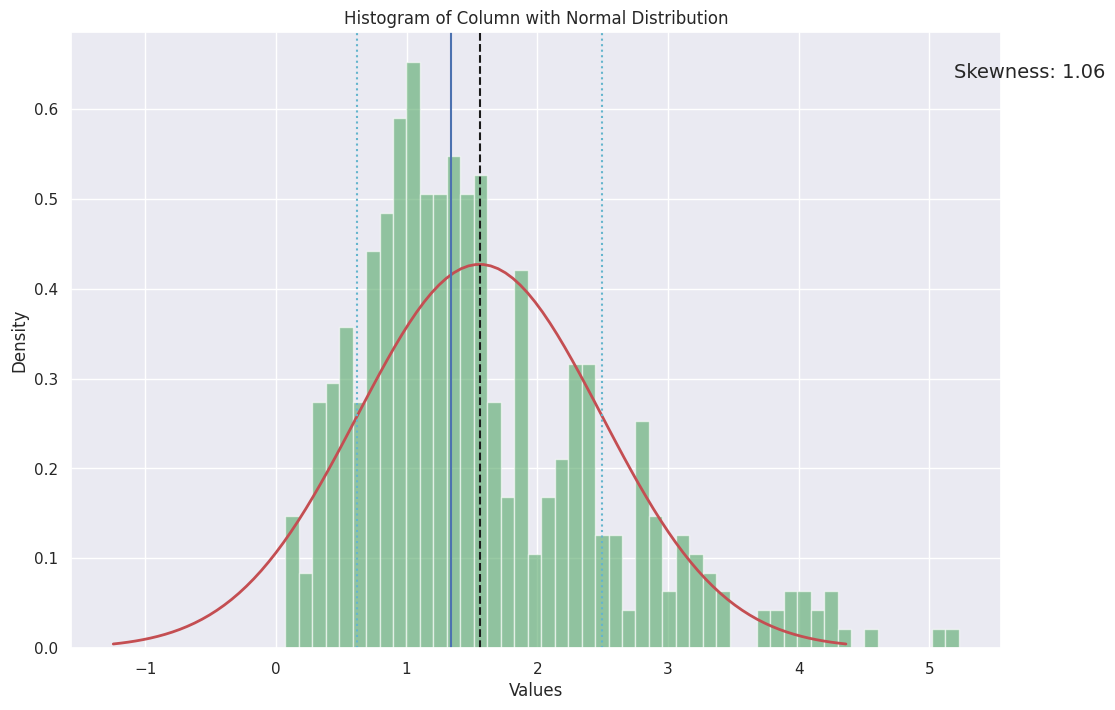

In [ ]:
# Investigate Yield Data
# Select the column you want to create a histogram for
column = data['JoinedYld']

# Calculate the mean, median, and standard deviation
mean = column.mean()
median = column.median()
std = column.std()

# Calculate the skewness
skewness = column.skew()

# Fit a normal distribution to the data
mu, std_fit = stats.norm.fit(column)

# Plot the histogram
n, bins, patches = plt.hist(column, bins=50, density=True, alpha=0.6, color='g')

# Plot the normal distribution
x = np.linspace(mu - 3*std_fit, mu + 3*std_fit, 100)
y = stats.norm.pdf(x, mu, std_fit)
plt.plot(x, y, 'r', linewidth=2)

# Add mean, median, and standard deviation lines
plt.axvline(mean, color='k', linestyle='--', label='Mean')
plt.axvline(median, color='b', linestyle='-', label='Median')
plt.axvline(mean + std, color='c', linestyle=':', label='+1 SD')
plt.axvline(mean - std, color='c', linestyle=':', label='-1 SD')

# Add a title and labels to the x and y axes
plt.title('Histogram of Column with Normal Distribution')
plt.xlabel('Values')
plt.ylabel('Density')

# Add skewness text
plt.text(0.95, 0.95, 'Skewness: {:.2f}'.format(skewness),
         horizontalalignment='left',
         verticalalignment='top',
         transform=plt.gca().transAxes)

# # Add a legend
# plt.legend()

# Show the plot
plt.show()



In [ ]:
features = train
features.columns, features.shape

(Index(['Year', 'Yield', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2',
        'ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi', 'msavi', 'gci', 'gli',
        'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2', 'rdvi', 'gvi', 'ndii',
        'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi', 'pssra', 'dvi',
        'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec', 'era5_mean_temp',
        'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp', 'era5m_min_temp',
        'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec', 'temp_MIN',
        'temp_MAX', 'temp_MEAN', 'temp_STD', 'temp_SUM', 'fpar', 'm_lai',
        'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp', 'npp', 'Tmst_AREA', 'Tmst_MIN',
        'Tmst_MAX', 'Tmst_RANGE', 'Tmst_MEAN', 'Tmst_STD', 'Tmst_SUM', 'Yield2',
        'mod_lst', 'ggcp10', 'final_Yld', 'JoinedYld'],
       dtype='object'),
 (461, 70))

In [ ]:
# TRAIN SPLIT
yld = train['JoinedYld']
yld.shape
pred = train.drop([ 'Year', 'Yield', 'blue', 'green', 'red', 'nir', 'swir1',
                         'swir2','Tmst_STD', 'Tmst_SUM', 'Yield2', 'ggcp10', 'final_Yld','Tmst_RANGE',
                         'Tmst_AREA','temp_STD','temp_SUM', 'JoinedYld'], axis=1)
# y_train

In [ ]:
pred.columns

Index(['ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi', 'msavi', 'gci', 'gli',
       'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2', 'rdvi', 'gvi', 'ndii',
       'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi', 'pssra', 'dvi',
       'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec', 'era5_mean_temp',
       'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp', 'era5m_min_temp',
       'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec', 'temp_MIN',
       'temp_MAX', 'temp_MEAN', 'fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi',
       'gpp', 'npp', 'Tmst_MIN', 'Tmst_MAX', 'Tmst_MEAN', 'mod_lst'],
      dtype='object')

In [ ]:
pred.shape,yld.shape

((461, 52), (461,))

In [ ]:
# y_train = train['Yield']
# x_train = features.drop(['Yield','county','code','evi', 'gci', 'gli',], axis=1)
# # x_train,y_train# sipi, savi, nsi, ndvi, ndmi,msavi, gndvi

In [ ]:
features = pred


In [ ]:
train['JoinedYld'].count()

461

**Hold-Out**

# RF MODEL TRAINING ITER1

In [ ]:
# RF Regressor & Fit
# create a classifier and fit
n_trees = 200
clf = RandomForestRegressor(n_trees,random_state = 42)
clf.fit(pred,yld)

RandomForestRegressor(n_estimators=200, random_state=42)

In [ ]:
feature_name=pred.columns

In [ ]:
feature_name

Index(['ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi', 'msavi', 'gci', 'gli',
       'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2', 'rdvi', 'gvi', 'ndii',
       'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi', 'pssra', 'dvi',
       'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec', 'era5_mean_temp',
       'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp', 'era5m_min_temp',
       'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec', 'temp_MIN',
       'temp_MAX', 'temp_MEAN', 'fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi',
       'gpp', 'npp', 'Tmst_MIN', 'Tmst_MAX', 'Tmst_MEAN', 'mod_lst'],
      dtype='object')

In [ ]:
# convert the estimator into a list of strings
# this function also works with the ensemble.ExtraTrees estimator
# trees = ml.rf_to_strings(clf,feature_name,2,"REGRESSION")


In [ ]:
# print the first tree to see the result
# print(trees[0])

In [ ]:
# number of trees we converted should equal the number of trees we defined for the model
# len(trees) == n_trees

In [ ]:
# create a ee classifier to use with ee objects from the trees
# ee_classifier = ml.strings_to_classifier(trees)



```
# Feature Selection
```

# Feature Importance

In [ ]:
# Feature Selection
# Feature Importance
clf.feature_importances_

array([0.00095541, 0.00089115, 0.00865428, 0.00113079, 0.0065009 ,
       0.00979437, 0.0009537 , 0.00211833, 0.0058811 , 0.00866527,
       0.00166057, 0.00086255, 0.00233454, 0.0020705 , 0.00124599,
       0.00150363, 0.01010613, 0.0068464 , 0.00317547, 0.00817847,
       0.0006608 , 0.00239754, 0.00492636, 0.01804289, 0.0026042 ,
       0.0020536 , 0.39653548, 0.01428357, 0.0137599 , 0.04657113,
       0.01445207, 0.03710307, 0.03680408, 0.01055427, 0.01986988,
       0.01109583, 0.01115693, 0.0132585 , 0.01750101, 0.10285387,
       0.01919159, 0.00536607, 0.00579438, 0.00475122, 0.00564035,
       0.01184182, 0.01519328, 0.02063573, 0.00451078, 0.02219626,
       0.00988108, 0.01498291])

In [ ]:
clf.n_features_in_

52

In [ ]:
feature_importance = pd.DataFrame(clf.feature_importances_,columns =['Importance'])
feature_importance['Features'] = clf.feature_names_in_
feature_importance.sort_values(by=['Importance'], ascending=False)

,Importance,Features
0,0.403568,era5d_prec
1,0.147450,temp_MAX
6,0.080385,era5_min_temp
2,0.062073,era5m_prec
3,0.056694,era5m_max_temp
10,0.048464,chirpsm_prec
8,0.044955,era5_wind
5,0.043210,wdvi
4,0.040324,temp_MIN
7,0.030135,m_ndmi


In [ ]:
sorted_idx = clf.feature_importances_.argsort()
sorted_idx.shape

(52,)

In [ ]:
# features = data.columns[:13]
features = pred.columns
features.shape

(52,)

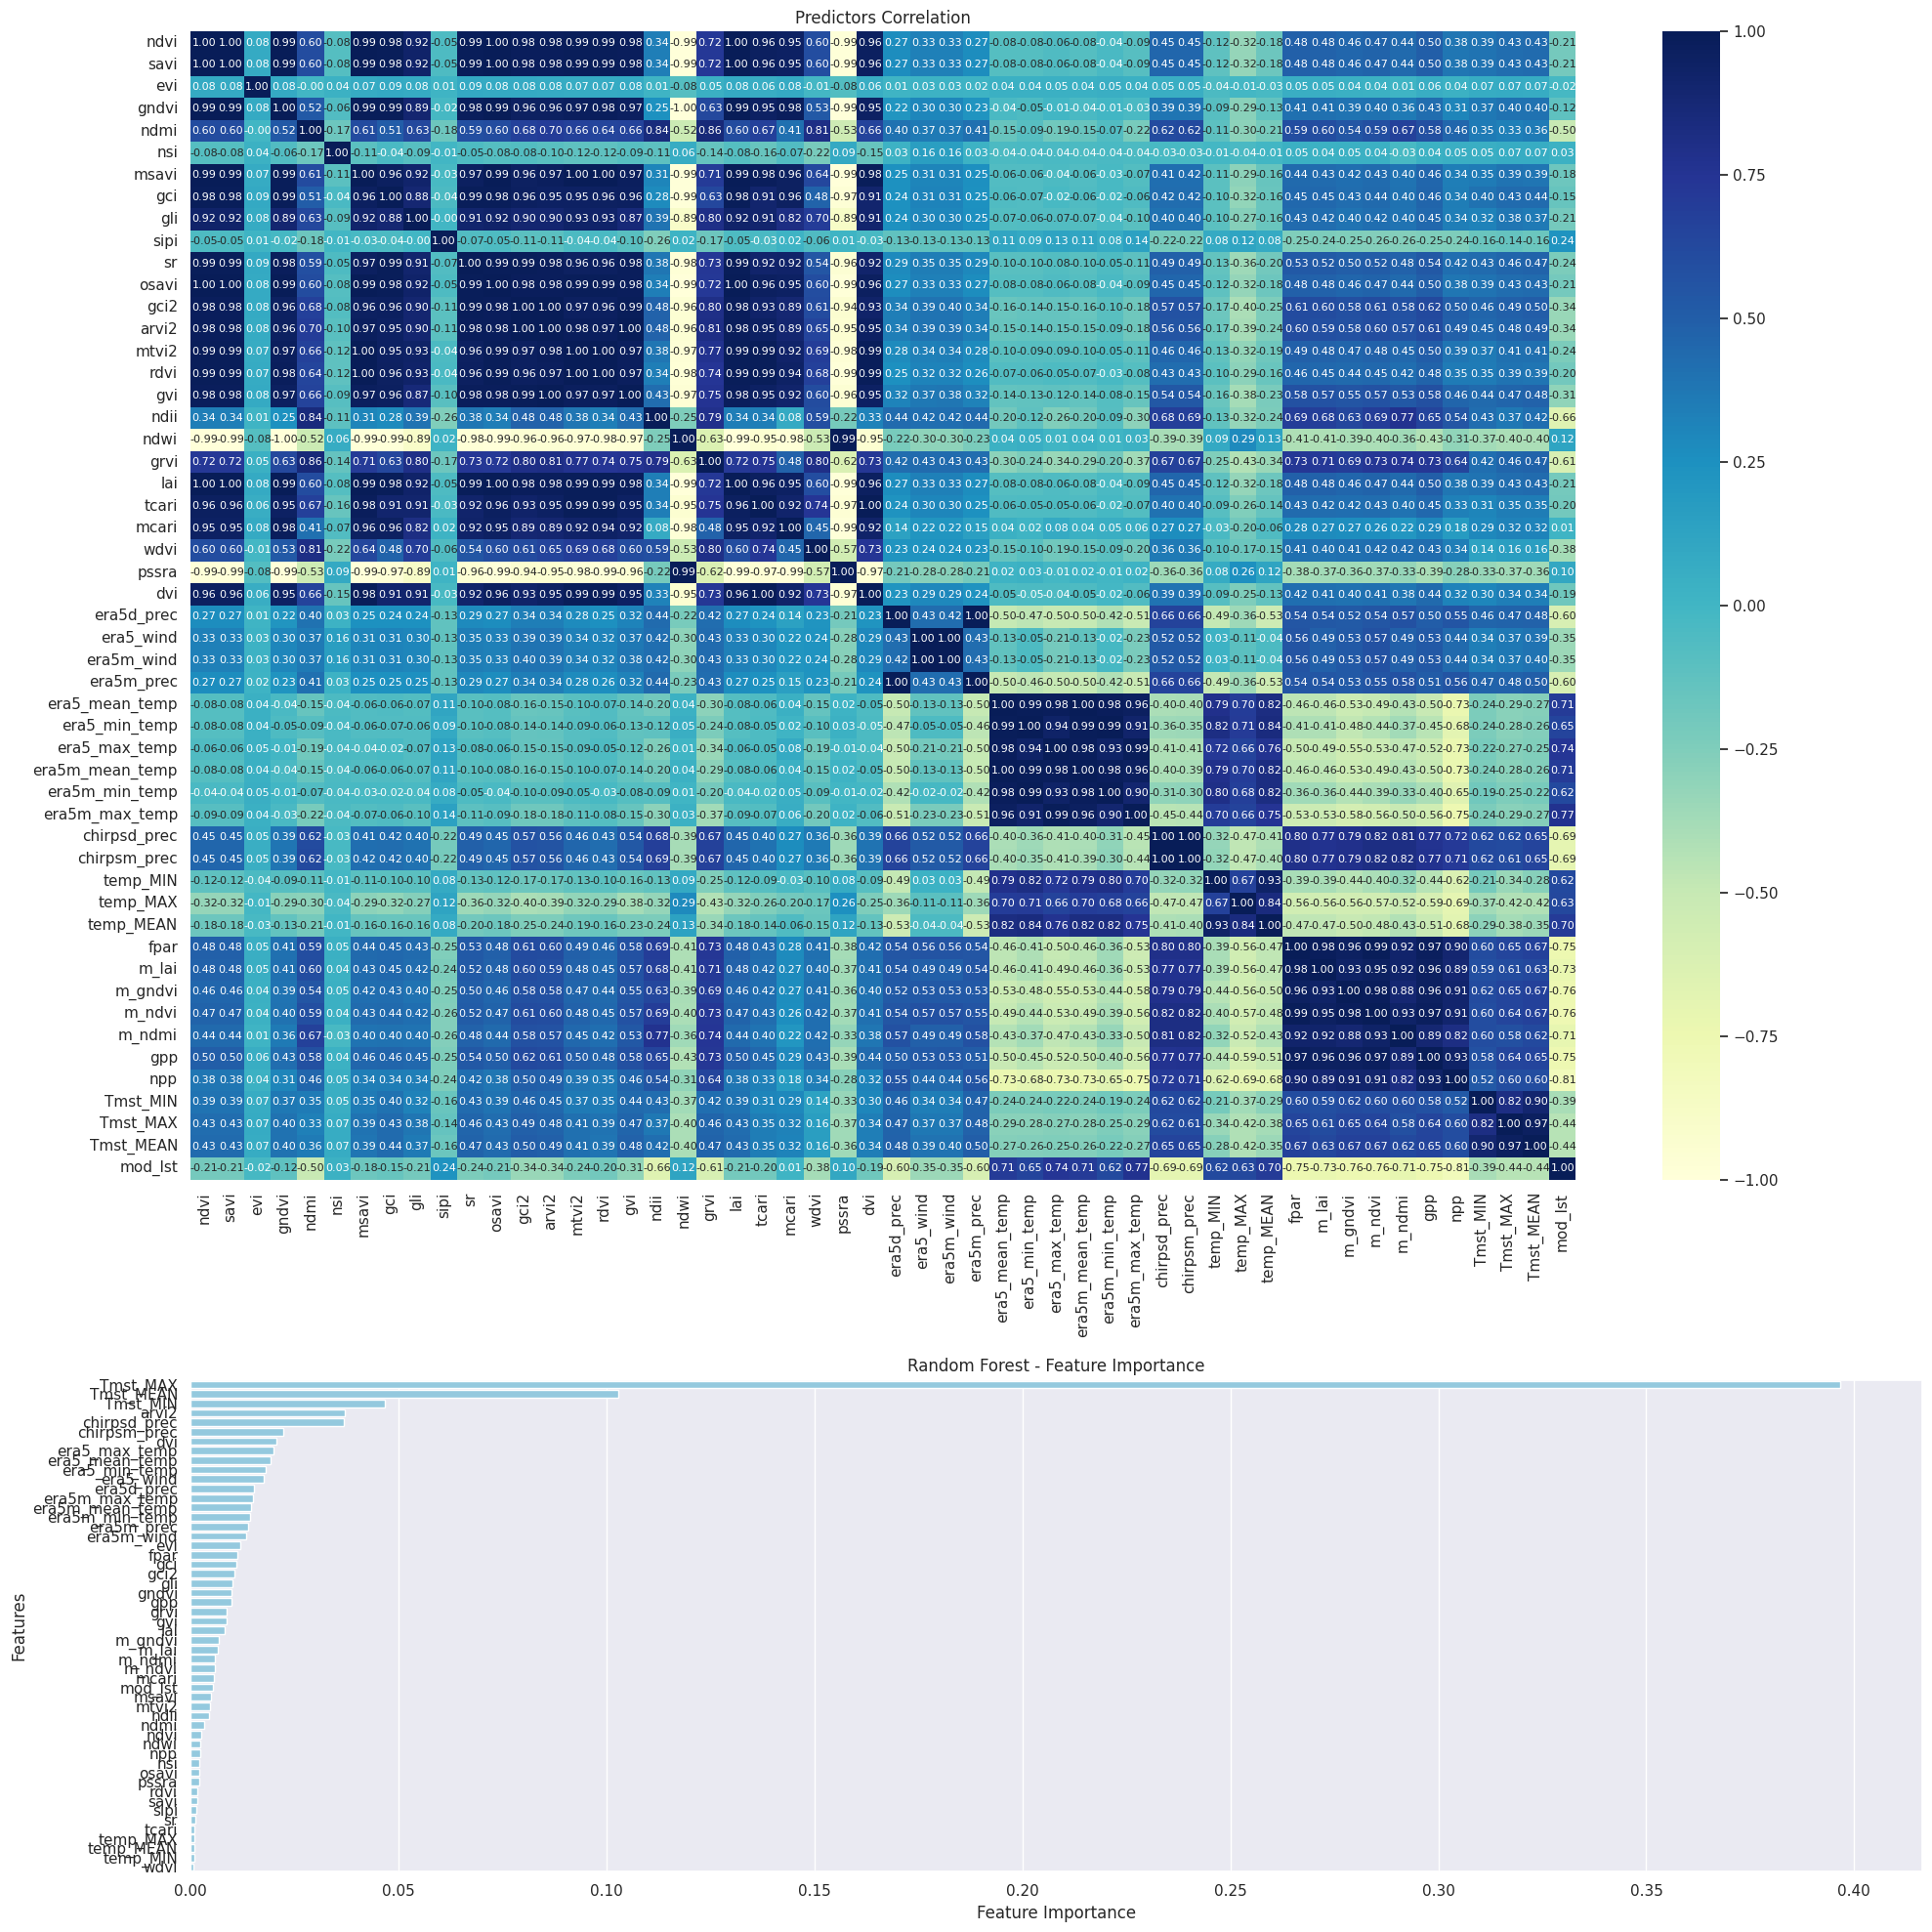

In [ ]:
# Create figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 20), gridspec_kw={'height_ratios': [0.70, 0.30]})

# Plot heatmap
sns.heatmap(pred.corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax1,annot_kws={"fontsize": 8})
ax1.set_title("Predictors Correlation")

# Plot horizontal bar plot
totals = feature_importance.groupby('Features')["Importance"].mean().sort_values(ascending=False)
sns.barplot(y=totals.index.sort_values(ascending=True), x=totals.values, color="skyblue", ax=ax2,orient='h',)
ax2.set_title("Random Forest - Feature Importance")
ax2.set_xlabel("Feature Importance")

plt.tight_layout()  # Ensures proper spacing between plots
plt.show()

In [ ]:
sns.set(font_scale=0.75)

**Permutation Based Importance**

Randomly shuffles each feature and compute the change in the model’s performance. The features which impact the performance the most are the most important ones

**Pros:**
- overcome drawbacks of default feature importance computed with mean impurity decrease (**Gini importance**)

**Cons:**
- can have problem with highly-correlated features

In [ ]:
# perm_importance = permutation_importance(clf, X_test, y_test)
# perm_importance.importances_mean

In [ ]:
# feat = ['fpar', 'lai', 'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp', 'NPP', 'evi',
      #  'gci', 'gli', 'gndvi', 'msavi', 'ndmi', 'ndvi', 'nsi', 'savi', 'sipi']

In [ ]:
# sorted_idx = perm_importance.importances_mean.argsort()
# plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")
# NPP,gpp,m_gndvi,sipi,m_ndmi,nsi,m_ndvi,ndmi,lai,gndvi,fpar

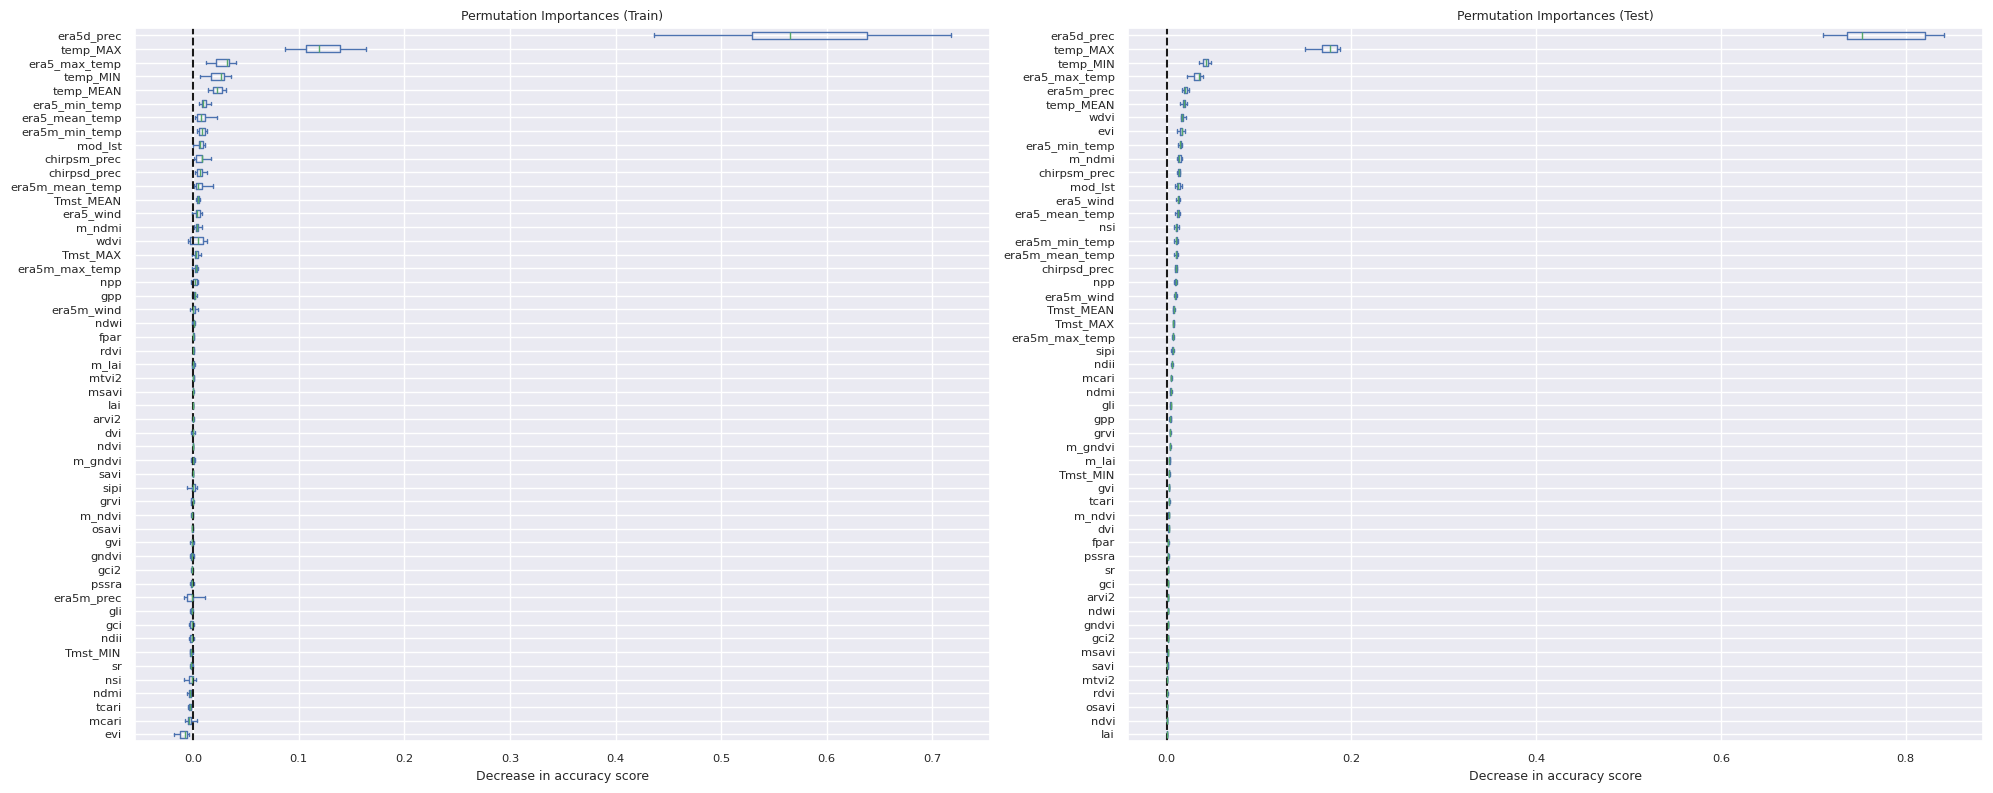

In [ ]:
#  Plotting Permutation Importance on train and test data can give a hint if there is an overfitting.
# Features that are likely to be useful and lead to overfitting will have a higher Permutation Importance weight on train data
#  and a lower or almost zero weight on test data.
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

clf = RandomForestRegressor(200,random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(pred,yld, test_size = 0.6, random_state=1)
main_pipeline = clf.fit(X_test,y_test)

pi_train = permutation_importance(
    main_pipeline,
    X_train, y_train,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

sorted_importances_idx = pi_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    pi_train.importances[sorted_importances_idx].T,
    columns=pred.columns[sorted_importances_idx],
)


pi_test = permutation_importance(
    main_pipeline,
    X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

sorted_importances_idx = pi_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    pi_test.importances[sorted_importances_idx].T,
    columns=pred.columns[sorted_importances_idx],
)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

ax1 = importances_train.plot.box(vert=False, whis=10, ax=ax1)
ax1.set_title("Permutation Importances (Train)")
ax1.axvline(x=0, color="k", linestyle="--")
ax1.set_xlabel("Decrease in accuracy score")
ax1.figure.tight_layout()

ax2 = importances_test.plot.box(vert=False, whis=10, ax=ax2)
ax2.set_title("Permutation Importances (Test)")
ax2.axvline(x=0, color="k", linestyle="--")
ax2.set_xlabel("Decrease in accuracy score")
ax2.figure.tight_layout()

**Feature Importance Computed with SHAP Values**

(it is model-agnostic) to compute the feature importances from the Random Forest. It is using the Shapley values from game theory to estimate the how does each feature contribute to the prediction.



In [ ]:
!pip install shap

In [ ]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(pred)

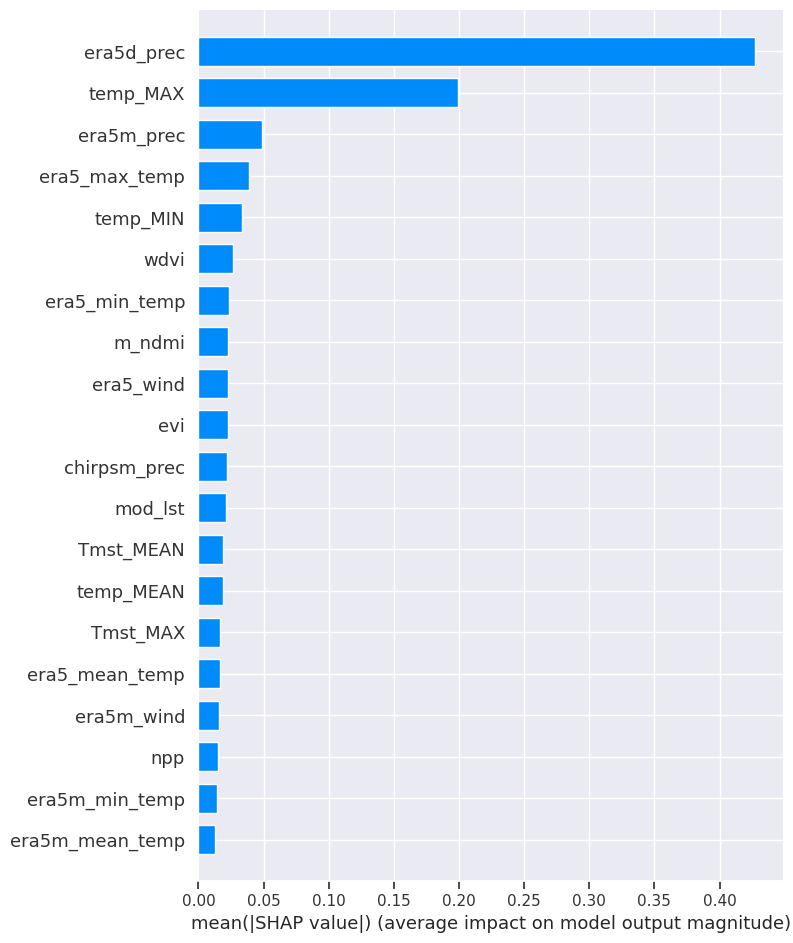

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


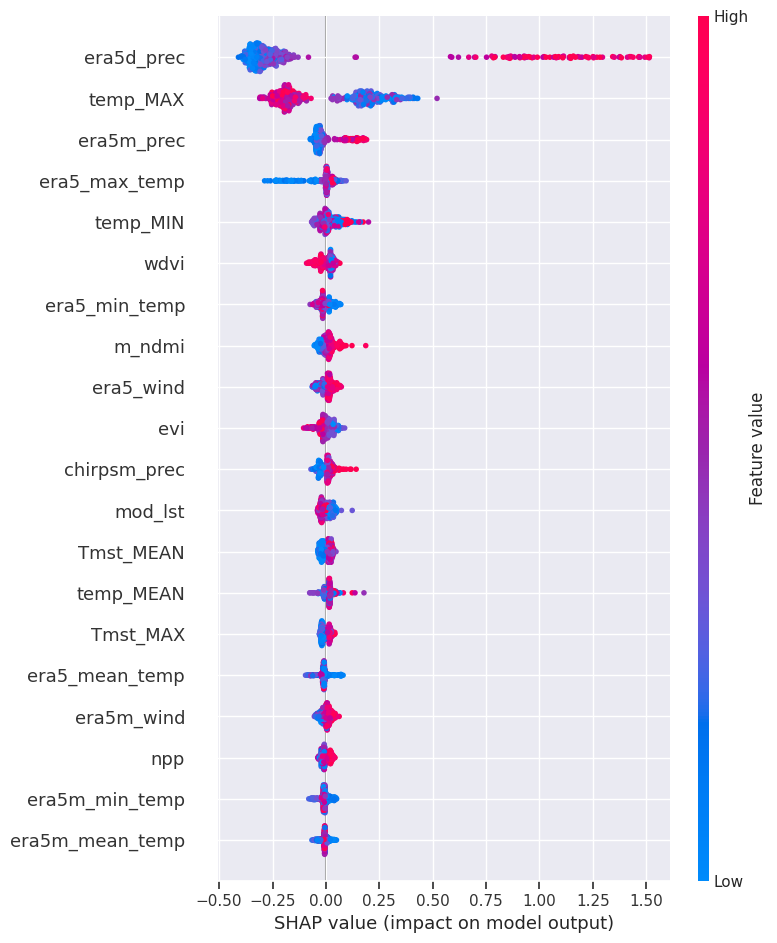

In [ ]:
shap.summary_plot(shap_values, pred)


# Visualizations

In [ ]:
# fig = plt.figure()
# plt.subplots(figsize=(30, 15))

# ax1 = plt.subplot(3,4,1)
# plt.scatter(data['ndvi'],data['Yield'])
# ax1.title.set_text('NDVI')
# ax1.margins(0.05)

# ax2 = plt.subplot(3,4,2)
# plt.scatter(data['NPP'],data['Yield'])
# ax2.title.set_text('NPP')
# ax2.margins(0.05)

In [ ]:
# fig = plt.figure()
# plt.subplots(figsize=(30, 15))

# ax1 = plt.subplot(3,4,1)
# plt.scatter(data['ndvi'],data['Yield'])
# ax1.title.set_text('NDVI')
# ax1.margins(0.05)

# ax2 = plt.subplot(3,4,2)
# plt.scatter(data['NPP'],data['Yield'])
# ax2.title.set_text('NPP')
# ax2.margins(0.05)
# ax3 = plt.subplot(3,4,3)
# plt.scatter(data['gpp'],data['Yield'])
# ax3.title.set_text('GPP')
# ax3.margins(0.05)
# ax4 = plt.subplot(3,4,4)
# plt.scatter(data['lai'],data['Yield'])
# ax4.title.set_text('LAI')
# ax4.margins(0.05)
# ax5 = plt.subplot(3,4,5)
# plt.scatter(data['ndmi'],data['Yield'])
# ax5.title.set_text('NDMI')

# ax6 = plt.subplot(3,4,6)
# plt.scatter(data['fpar'],data['Yield'])
# ax6.title.set_text('FPAR')

# ax7 = plt.subplot(3,4,7)
# plt.scatter(data['gndvi'],data['Yield'])
# ax7.title.set_text('GNDVI')

# fig.tight_layout()

# plt.show()

In [ ]:
# fig, axs = plt.subplots(2, 2)
# axs[0, 0].scatter(data['msavi'],data['Yield'])
# axs[0, 0].set_title('MSAVI')
# axs[0, 1].scatter(data['sipi'],data['Yield'])
# axs[0, 1].set_title('SIPI')
# axs[1, 0].scatter(data['ndvi'],data['Yield'])
# axs[1, 0].set_title('NDVI')
# axs[1, 1].scatter(data['evi'],data['Yield'])
# axs[1, 1].set_title('EVI')

# for ax in axs.flat:
#     ax.set(xlabel='Values', ylabel='Yield(mt/ha)')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [ ]:
# g = sns.PairGrid(data)
# g.map(sns.scatterplot)

In [ ]:
# grid = sns.FacetGrid(data, col = "Year", hue = "Year", col_wrap=5)
# grid.map(sns.scatterplot, "sipi", "Yield")

# grid.add_legend()

# plt.show()

In [ ]:
# fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# fig.suptitle('Box plots with data')

# sns.boxplot(ax=axes[0, 0], data=data, x='sipi', y='Yield')
# sns.boxplot(ax=axes[0, 1], data=data, x='ndvi', y='Yield')
# sns.boxplot(ax=axes[0, 2], data=data, x='ndmi', y='Yield')
# sns.boxplot(ax=axes[1, 0], data=data, x='gndvi', y='Yield')
# sns.boxplot(ax=axes[1, 1], data=data, x='msavi', y='Yield')
# sns.boxplot(ax=axes[1, 2], data=data, x='savi', y='Yield')
# sns.boxplot(ax=axes[2, 0], data=data, x='nsi', y='Yield')




```
# Leave One Year Out Cross Validation
```

# LOYOCV

In [ ]:
logo = LeaveOneGroupOut()

In [ ]:
group = data['Year']

In [ ]:
logo.get_n_splits(groups=group)

11

In [ ]:
# cross_val_score : Calculate score for each CV split.
# cross_validate : Calculate one or more scores and timings for each CV split.
# Passing these predictions into an evaluation metric may not be a valid
# way to measure generalization performance.

# cross_validate : To run cross-validation on multiple metrics and also to
#     return train scores, fit times and score times.

# cross_val_predict : Get predictions from each split of cross-validation for
#     diagnostic purposes.

# sklearn.metrics.make_scorer : Make a scorer from a performance metric or
#     loss function

In [ ]:
scores = cross_val_score(clf,pred,yld,groups=group,scoring='neg_mean_squared_error',
                         cv=logo,n_jobs=-1)
scores

array([-0.34887968, -0.19556412, -0.25182387, -0.20660158, -0.25789457,
       -0.26743   , -0.26490208, -0.16669461, -0.27624889, -0.22076955,
       -0.68308427])

In [ ]:
from sklearn.model_selection import cross_validate,cross_val_predict,permutation_test_score
from sklearn.metrics import make_scorer

In [ ]:
# Run cross-validation on R2, MSE, RMSE, MAPE metrics and also to return train scores, fit times and score times

cross_validate_results = cross_validate(clf,pred,yld,groups=group,
                                        scoring=('r2', 'neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_percentage_error'),
                                        return_train_score=True,cv=logo,n_jobs=-1)

In [ ]:
cross_validate_results.keys()


dict_keys(['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_neg_mean_squared_error', 'train_neg_mean_squared_error', 'test_neg_root_mean_squared_error', 'train_neg_root_mean_squared_error', 'test_neg_mean_absolute_percentage_error', 'train_neg_mean_absolute_percentage_error'])

In [ ]:
metrics = pd.DataFrame(cross_validate_results, columns = ['train_r2','test_r2',
                                                          'train_neg_mean_squared_error','test_neg_mean_squared_error',
                                                          'train_neg_root_mean_squared_error','test_neg_root_mean_squared_error',
                                                          'train_neg_mean_absolute_percentage_error','test_neg_mean_absolute_percentage_error'])
years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]
metrics['Year'] = years
metrics

,train_r2,test_r2,train_neg_mean_squared_error,test_neg_mean_squared_error,train_neg_root_mean_squared_error,test_neg_root_mean_squared_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,Year
0,0.957985,0.604741,-0.036348,-0.348880,-0.190651,-0.590660,-0.176508,-0.275509,2010
1,0.954643,0.767900,-0.039720,-0.195564,-0.199299,-0.442226,-0.173419,-0.520699,2011
2,0.954419,0.734173,-0.039334,-0.251824,-0.198329,-0.501821,-0.168396,-0.659511,2012
3,0.956854,0.748674,-0.037882,-0.206602,-0.194633,-0.454534,-0.171992,-0.332249,2013
4,0.956961,0.689787,-0.037682,-0.257895,-0.194120,-0.507833,-0.169846,-0.349699,2014
5,0.959070,0.549540,-0.036872,-0.267430,-0.192022,-0.517136,-0.167543,-0.541831,2015
6,0.955984,0.705977,-0.038099,-0.264902,-0.195189,-0.514686,-0.161279,-0.849810,2016
7,0.955149,0.766888,-0.039835,-0.166695,-0.199588,-0.408283,-0.175980,-0.317711,2017
8,0.955175,0.709377,-0.038780,-0.276249,-0.196926,-0.525594,-0.188801,-0.365473,2018
9,0.954243,0.708807,-0.040469,-0.220770,-0.201168,-0.469861,-0.177178,-0.385872,2019


In [ ]:
# Get predictions from each split of cross-validation for diagnostic purposes
cross_val_prediction = cross_val_predict(clf,pred,yld,groups=group,cv=logo,n_jobs=-1,)

In [ ]:
cross_val_prediction.size


461

In [ ]:
# Evaluate the significance of a cross-validated score with permutations.
# score,permutation_test_scores,pvalue = permutation_test_score(clf,pred,yld,groups=group,cv=logo,n_jobs=-1)


In [ ]:
from numpy import mean
from numpy import absolute
from numpy import sqrt
from sklearn.metrics import r2_score

In [ ]:
#view mean absolute error
mean(absolute(scores))

0.28544483946948185

In [ ]:
data['predictions'] = cross_val_prediction
data.describe()

<ipython-input-425-94bd0a306e79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['predictions'] = cross_val_prediction


,Year,Yield,blue,green,red,nir,swir1,swir2,ndvi,savi,...,Tmst_RANGE,Tmst_MEAN,Tmst_STD,Tmst_SUM,Yield2,mod_lst,ggcp10,final_Yld,JoinedYld,predictions
count,461.000000,378.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,...,461.000000,461.000000,461.000000,461.000000,377.000000,461.000000,461.000000,377.000000,461.000000,461.000000
mean,2014.989154,1.565389,15413.454259,16035.975727,16347.604134,21227.513130,18042.259340,14523.145163,0.152170,0.228252,...,83.067897,100.195398,19.315664,10289.432996,1.571220,15053.640804,2.121945,1.536283,1.558705,1.581713
std,3.160540,0.935836,5396.852876,4722.485294,5078.652003,2472.150062,2630.079343,1723.876089,0.093239,0.139857,...,69.935337,86.706050,15.901291,16675.709297,0.937679,200.463762,1.175216,0.932666,0.935326,0.756502
min,2010.000000,0.073561,9143.756000,10170.156960,10070.378840,15201.186490,14264.674560,11113.324250,-0.125322,-0.187981,...,0.000000,0.000000,0.000000,0.000000,0.070000,14668.905120,0.015409,0.071642,0.071642,0.439597
25%,2012.000000,0.897919,11440.506530,12569.025170,12726.295270,19374.466470,16126.576420,13175.964870,0.104337,0.156503,...,33.299999,11.487143,7.569266,758.600007,0.900000,14921.335210,1.364666,0.886684,0.901980,0.993951
50%,2015.000000,1.368918,14064.890690,14811.063700,14930.986940,20783.808090,17314.475710,14191.067040,0.168225,0.252335,...,66.599998,87.055883,15.909070,5918.016678,1.380000,15028.829250,2.199110,1.311205,1.337808,1.404392
75%,2018.000000,2.156738,17864.987290,18125.811950,18580.042740,22883.315890,19505.411060,15853.188390,0.219557,0.329329,...,121.200005,158.198156,26.893221,14614.299990,2.110000,15150.634030,2.957867,2.014130,2.078988,1.958115
max,2020.000000,5.090926,40761.130780,39770.558290,40505.574260,32026.710420,32362.643070,18865.725980,0.310899,0.466341,...,443.000000,389.870093,93.047153,264718.399900,5.090000,15878.890780,5.522266,5.224867,5.224867,4.014725


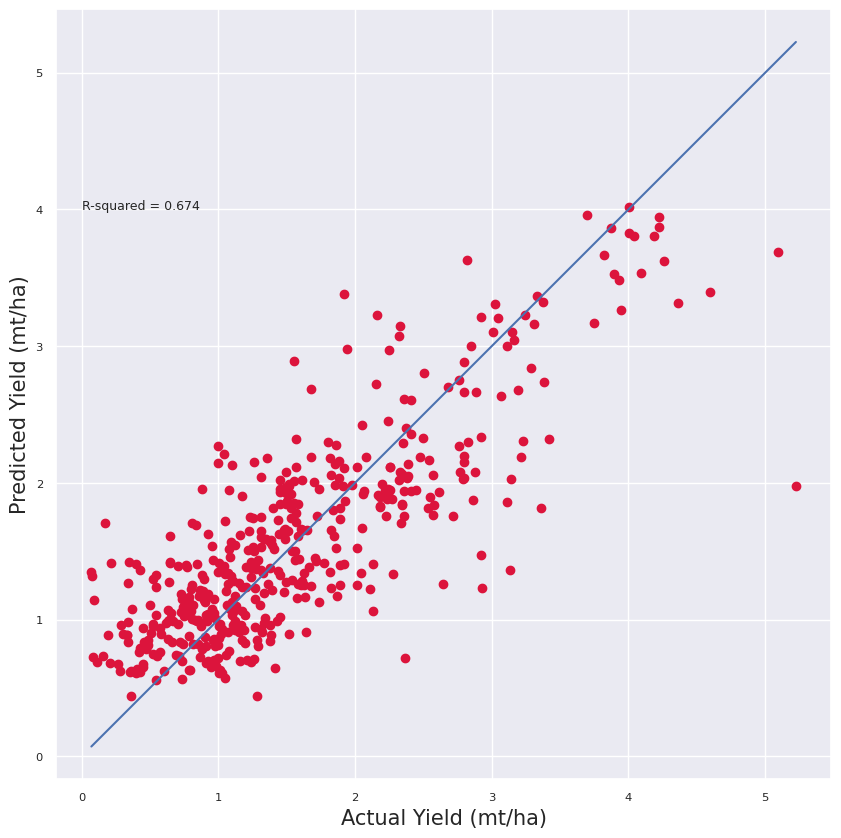

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(data['JoinedYld'], data['predictions'], c='crimson')
# plt.yscale('log')
# plt.xscale('log')
y_test = data['JoinedYld']
y_predicted = data['predictions']
p1 = max(max(data['predictions']), max(data['JoinedYld']))
p2 = min(min(data['predictions']), min(data['JoinedYld']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Yield (mt/ha)', fontsize=15)
plt.ylabel('Predicted Yield (mt/ha)', fontsize=15)
plt.axis('equal')
plt.annotate("R-squared = {:.3f}".format(r2_score(y_test, y_predicted)), (0, 4))
plt.show()



```
TRAINING WITH SELECTED FEATURES
```
# RF Model ITER2

In [ ]:
new_data = pd.DataFrame(data=data)
new_data.columns
# 'sipi', 'gci', 'gli', 'ndmi','msavi', 'gndvi','Yield'
# 'evi', 'gci', 'gli', 'gndvi', 'msavi', 'ndmi', 'ndvi', 'nsi', 'savi','sipi'

Index(['key', 'COUNTY', 'Year', 'Yield', 'blue', 'green', 'red', 'nir',
       'swir1', 'swir2', 'ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi',
       'msavi', 'gci', 'gli', 'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2',
       'rdvi', 'gvi', 'ndii', 'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi',
       'pssra', 'dvi', 'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec',
       'era5_mean_temp', 'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp',
       'era5m_min_temp', 'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec',
       'AREA', 'temp_MIN', 'temp_MAX', 'RANGE', 'temp_MEAN', 'temp_STD',
       'temp_SUM', 'fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp',
       'npp', 'Tmst_AREA', 'Tmst_MIN', 'Tmst_MAX', 'Tmst_RANGE', 'Tmst_MEAN',
       'Tmst_STD', 'Tmst_SUM', 'Yield2', 'mod_lst', 'ggcp10', 'final_Yld',
       'JoinedYld', 'predictions'],
      dtype='object')

In [ ]:
features= new_data

In [ ]:
features.shape

(461, 75)

In [ ]:
importances_test

,lai,ndvi,osavi,rdvi,mtvi2,savi,msavi,gci2,gndvi,ndwi,...,m_ndmi,era5_min_temp,evi,wdvi,temp_MEAN,era5m_prec,era5_max_temp,temp_MIN,temp_MAX,era5d_prec
0,0.000431,0.000422,0.000610,0.000820,0.000724,0.000710,0.000952,0.001093,0.001036,0.001374,...,0.011843,0.016166,0.017543,0.018073,0.018476,0.016889,0.035418,0.039385,0.181613,0.710665
1,0.000351,0.000545,0.000631,0.000665,0.000589,0.000682,0.000782,0.000988,0.000809,0.001253,...,0.012358,0.014345,0.014806,0.015961,0.019936,0.019966,0.028922,0.045636,0.168129,0.714201
2,0.000440,0.000432,0.000582,0.000731,0.000710,0.001001,0.000778,0.001046,0.001022,0.001224,...,0.014721,0.014482,0.016063,0.016448,0.018557,0.020433,0.036557,0.048376,0.176861,0.824027
3,0.000301,0.000417,0.000414,0.000556,0.000753,0.000594,0.000841,0.001286,0.001006,0.001218,...,0.015229,0.015572,0.012680,0.015980,0.015092,0.024295,0.032897,0.043106,0.187186,0.835147
4,0.000471,0.000552,0.000788,0.000777,0.000671,0.000848,0.000951,0.001196,0.001321,0.001553,...,0.011319,0.011894,0.011166,0.017808,0.016801,0.018320,0.039350,0.035236,0.149840,0.760323
5,0.000344,0.000412,0.000561,0.000691,0.000691,0.000734,0.000878,0.001213,0.001246,0.001331,...,0.011906,0.013022,0.016451,0.018469,0.018799,0.021862,0.037713,0.039784,0.169655,0.812739
6,0.000368,0.000539,0.000610,0.000558,0.000647,0.000742,0.000764,0.000992,0.001188,0.001409,...,0.011020,0.015896,0.016776,0.015657,0.018598,0.021210,0.026078,0.041860,0.185785,0.744802
7,0.000459,0.000528,0.000622,0.000718,0.000658,0.000857,0.001048,0.000993,0.001098,0.001482,...,0.016728,0.014600,0.019430,0.020629,0.020882,0.017825,0.022246,0.043636,0.166680,0.740573
8,0.000524,0.000565,0.000672,0.000628,0.000701,0.000755,0.000792,0.001063,0.001320,0.001482,...,0.014731,0.014389,0.014943,0.014944,0.014801,0.023075,0.035081,0.038984,0.185918,0.841681
9,0.000492,0.000549,0.000675,0.000761,0.000778,0.000811,0.000875,0.001241,0.001205,0.001344,...,0.015438,0.014849,0.016441,0.015461,0.022325,0.018628,0.034477,0.044384,0.176876,0.735578


In [ ]:
#  --# NPP,gpp,m_gndvi,sipi,m_ndmi,nsi,m_ndvi,ndmi,lai,gndvi,fpar
#  'fpar',  'lai', 'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp',
#        'NPP',
#        'gndvi','ndmi',  'nsi', 'sipi',
#        'Yield_y', 'predictions'

# VIF
# gndvi	1.946382
# ndmi	2.748858
# nsi	1.146534
# sipi	1.278859

In [ ]:
new_data.columns

Index(['key', 'COUNTY', 'Year', 'Yield', 'blue', 'green', 'red', 'nir',
       'swir1', 'swir2', 'ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi',
       'msavi', 'gci', 'gli', 'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2',
       'rdvi', 'gvi', 'ndii', 'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi',
       'pssra', 'dvi', 'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec',
       'era5_mean_temp', 'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp',
       'era5m_min_temp', 'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec',
       'AREA', 'temp_MIN', 'temp_MAX', 'RANGE', 'temp_MEAN', 'temp_STD',
       'temp_SUM', 'fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp',
       'npp', 'Tmst_AREA', 'Tmst_MIN', 'Tmst_MAX', 'Tmst_RANGE', 'Tmst_MEAN',
       'Tmst_STD', 'Tmst_SUM', 'Yield2', 'mod_lst', 'ggcp10', 'final_Yld',
       'JoinedYld', 'predictions'],
      dtype='object')

In [ ]:
# TRAIN SPLIT
yld2 = new_data['JoinedYld']
pred2 = new_data[['era5d_prec', 'temp_MAX', 'era5m_prec','era5m_max_temp', 'temp_MIN',  'wdvi','era5_min_temp', 'm_ndmi', 'era5_wind', 'evi', 'chirpsm_prec', 'mod_lst']]
# tamsat = new_data[['Tmst_AREA', 'Tmst_MIN', 'Tmst_MAX', 'Tmst_RANGE', 'Tmst_MEAN','Tmst_STD', 'Tmst_SUM']]
# tamsat.describe()

In [ ]:
pred2.columns

Index(['era5d_prec', 'temp_MAX', 'era5m_prec', 'era5m_max_temp', 'temp_MIN',
       'wdvi', 'era5_min_temp', 'm_ndmi', 'era5_wind', 'evi', 'chirpsm_prec',
       'mod_lst'],
      dtype='object')

In [ ]:
# y_train.shape

In [ ]:
# RF Regressor & Fit
# create a classifier and fit
n_trees = 200
clf = RandomForestRegressor(n_trees,random_state = 42)
clf.fit(pred2,yld2)

RandomForestRegressor(n_estimators=200, random_state=42)

In [ ]:
feature_name=pred2.columns
feature_name

Index(['era5d_prec', 'temp_MAX', 'era5m_prec', 'era5m_max_temp', 'temp_MIN',
       'wdvi', 'era5_min_temp', 'm_ndmi', 'era5_wind', 'evi', 'chirpsm_prec',
       'mod_lst'],
      dtype='object')

In [ ]:
# convert the estimator into a list of strings
# this function also works with the ensemble.ExtraTrees estimator
# trees = ml.rf_to_strings(clf,feature_name,2,"REGRESSION")

In [ ]:
# number of trees we converted should equal the number of trees we defined for the model
# len(trees) == n_trees

In [ ]:
# create a ee classifier to use with ee objects from the trees
# ee_classifier = ml.strings_to_classifier(trees)

# Export Classifier

In [ ]:
# ee_classifier.getInfo()

In [ ]:
# joblib.dump(clf, "./random_forest.joblib")

In [ ]:
# ee_serialized = ee_classifier.serialize()

In [ ]:
# user_id = geemap.ee_user_id()
# user_id


In [ ]:
# specify asset id where to save trees
# be sure to change  to your ee user name
# asset_id = user_id + "/random_forest_"
# asset_id

In [ ]:
# kick off an export process so it will be saved to the ee asset
# ml.export_trees_to_fc(trees, asset_id)

# this will kick off an export task, so wait a few minutes before moving on

In [ ]:
# # read the exported tree feature collection
# rf_fc = ee.FeatureCollection(asset_id)

# # convert it to a classifier, very similar to the `ml.trees_to_classifier` function
# another_classifier = ml.fc_to_classifier(rf_fc)

# # classify the image again but with the classifier from the persisted trees
# classified = image.select(feature_names).classify(another_classifier)

In [ ]:
# import os

# out_csv = os.path.expanduser("/content/drive/MyDrive/trees.csv")

In [ ]:
# ml.trees_to_csv(trees, out_csv)

In [ ]:
# another_classifier = ml.csv_to_classifier(out_csv)

In [ ]:
# classified = image.select(feature_names).classify(another_classifier)

In [ ]:
# task = ee.batch.Export.table.toAsset(**{
#     'collection'=encodeFeatureCollection(decisionTrees),
#     'description'='export_classifier',
#     'assetId'='users/Prod/ee_classifier',
# })
# task.start()

# LOYOCV2

In [ ]:
#  Feature Importance
clf.feature_importances_

array([0.40356845, 0.1474499 , 0.06207336, 0.05669401, 0.04032402,
       0.04320993, 0.08038509, 0.03013452, 0.04495535, 0.0187892 ,
       0.04846389, 0.02395228])

In [ ]:
features = pred2.columns
features


Index(['era5d_prec', 'temp_MAX', 'era5m_prec', 'era5m_max_temp', 'temp_MIN',
       'wdvi', 'era5_min_temp', 'm_ndmi', 'era5_wind', 'evi', 'chirpsm_prec',
       'mod_lst'],
      dtype='object')

In [ ]:
logo = LeaveOneGroupOut()

In [ ]:
group = new_data['Year']

In [ ]:
logo.get_n_splits(groups=group)

11

In [ ]:
scores = cross_val_score(clf,pred2,yld2,groups=group,scoring='neg_mean_absolute_percentage_error',
                         cv=logo,n_jobs=-1)

In [ ]:
scores

array([-0.27238306, -0.51534596, -0.60133298, -0.34084442, -0.34762474,
       -0.4684547 , -0.80170714, -0.31482397, -0.33973683, -0.39976514,
       -0.72700626])

In [ ]:
from sklearn.model_selection import cross_validate,cross_val_predict,permutation_test_score
from sklearn.metrics import make_scorer

In [ ]:
cross_validate_results = cross_validate(clf,pred2,yld2,groups=group,scoring=('r2', 'neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_percentage_error'),return_train_score=True, return_estimator=True,
                                        cv=logo,n_jobs=-1)

In [ ]:
# cross_validate_results

In [ ]:
metrics = pd.DataFrame(cross_validate_results, columns = ['train_r2','test_r2',
                                                          'train_neg_mean_squared_error','test_neg_mean_squared_error',
                                                          'train_neg_root_mean_squared_error','test_neg_root_mean_squared_error',
                                                          'train_neg_mean_absolute_percentage_error','test_neg_mean_absolute_percentage_error'])
metrics['Year'] = years
metrics

,train_r2,test_r2,train_neg_mean_squared_error,test_neg_mean_squared_error,train_neg_root_mean_squared_error,test_neg_root_mean_squared_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,Year
0,0.958832,0.588039,-0.035615,-0.363622,-0.188720,-0.603010,-0.171320,-0.272383,2010
1,0.955196,0.760285,-0.039236,-0.201980,-0.198081,-0.449422,-0.168162,-0.515346,2011
2,0.956538,0.751382,-0.037506,-0.235521,-0.193664,-0.485305,-0.160597,-0.601333,2012
3,0.957116,0.714693,-0.037652,-0.234535,-0.194042,-0.484288,-0.168521,-0.340844,2013
4,0.958902,0.661344,-0.035983,-0.281541,-0.189693,-0.530604,-0.166027,-0.347625,2014
5,0.960305,0.606117,-0.035760,-0.233841,-0.189104,-0.483571,-0.163347,-0.468455,2015
6,0.955821,0.729355,-0.038240,-0.243840,-0.195551,-0.493801,-0.157732,-0.801707,2016
7,0.955708,0.774767,-0.039339,-0.161061,-0.198340,-0.401323,-0.172793,-0.314824,2017
8,0.956693,0.710842,-0.037467,-0.274856,-0.193565,-0.524268,-0.173470,-0.339737,2018
9,0.957012,0.735604,-0.038020,-0.200454,-0.194987,-0.447721,-0.166111,-0.399765,2019


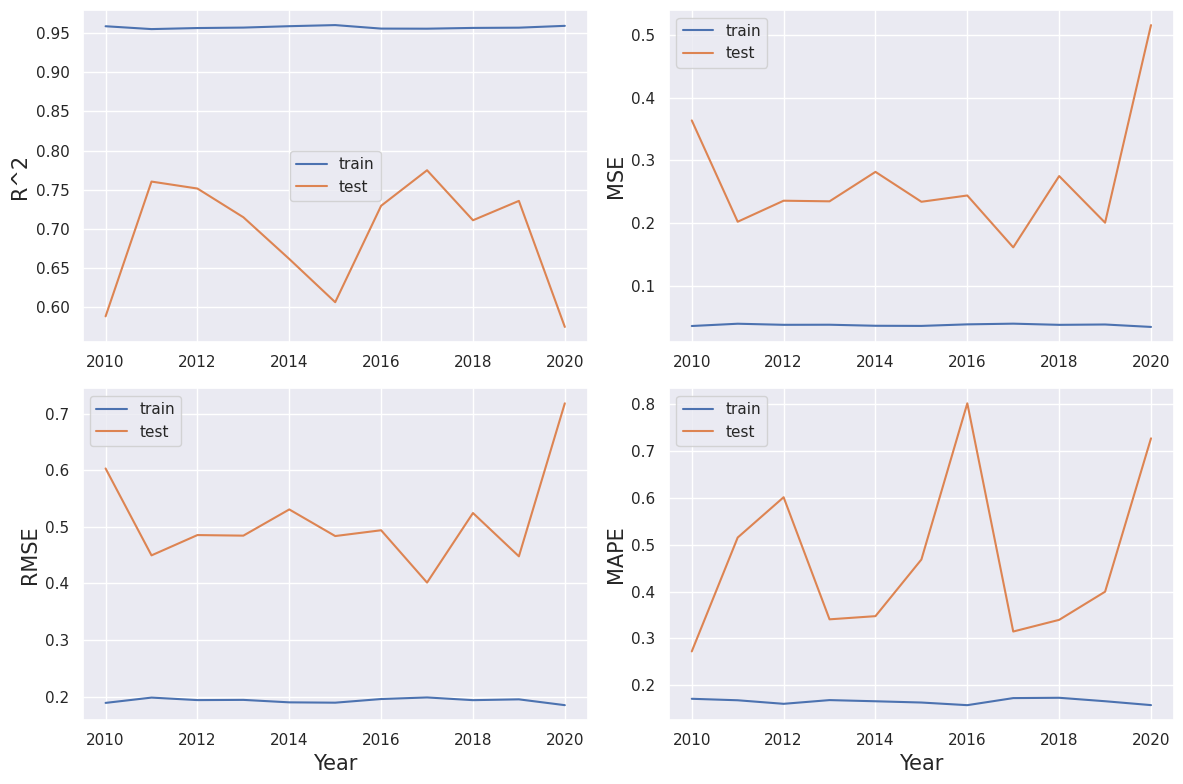

In [ ]:
fig = plt.figure()
sns.set(font_scale=1)
ax1 = plt.subplot(2,2,1)

plt.plot(metrics['Year'],metrics['train_r2'],label='train')
plt.plot(metrics['Year'],metrics['test_r2'],label='test')
# ax1.title.set_text('R^2')
ax1.legend()
ax1.set_ylabel('R^2', fontsize=15)
# ax1.set_xlabel('Year', fontsize=15)

ax2 = plt.subplot(2,2,2)
plt.plot(metrics['Year'],(metrics['train_neg_mean_squared_error']*-1),label='train')
plt.plot(metrics['Year'],(metrics['test_neg_mean_squared_error']*-1),label='test')
# ax2.title.set_text('MSE')
ax2.legend()
ax2.set_ylabel('MSE', fontsize=15)
# ax2.set_xlabel('Year', fontsize=15)

ax3 = plt.subplot(2,2,3)
plt.plot(metrics['Year'],(metrics['train_neg_root_mean_squared_error']*-1),label='train')
plt.plot(metrics['Year'],(metrics['test_neg_root_mean_squared_error']*-1),label='test')
# ax3.title.set_text('RMSE')
ax3.set_ylabel('RMSE', fontsize=15)
ax3.set_xlabel('Year', fontsize=15)
ax3.legend()

ax4 = plt.subplot(2,2,4)
plt.plot(metrics['Year'],(metrics['train_neg_mean_absolute_percentage_error']*-1),label='train')
plt.plot(metrics['Year'],(metrics['test_neg_mean_absolute_percentage_error']*-1),label='test')
# ax2.title.set_text('MSE')
ax4.legend()
ax4.set_ylabel('MAPE', fontsize=15)
ax4.set_xlabel('Year', fontsize=15)

# Labels to use in the legend for each line
labels = ["Train", "Test"]

fig.tight_layout()
# fig.legend([ax3, ax3], labels=labels,loc="upper right")


In [ ]:
cross_val_prediction = cross_val_predict(clf,pred2,yld2,groups=group,cv=logo,n_jobs=-1,)

In [ ]:
# EVALUATE HOW GOOD THE MODEL IS
# permutation_test_scores = permutation_test_score(clf,x_train,y_train,groups=group,cv=logo,n_jobs=-1)


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error


In [ ]:
# permutation_test_scores

In [ ]:
#view mean absolute error
mean(absolute(scores))

0.46627501840400404

In [ ]:
new_data['prediction2'] = cross_val_prediction
new_data

,key,COUNTY,Year,Yield,blue,green,red,nir,swir1,swir2,...,Tmst_MEAN,Tmst_STD,Tmst_SUM,Yield2,mod_lst,ggcp10,final_Yld,JoinedYld,predictions,prediction2
0,2010_BARINGO,BARINGO,2010,2.446140,13466.61207,13579.56526,14037.68821,18064.05894,16139.75614,12884.67164,...,165.862906,26.893221,27201.516640,NaN,14969.65208,1.202656,NaN,2.446140,1.946652,1.826374
1,2010_BOMET,BOMET,2010,2.534296,9273.87625,10270.83435,10170.83956,18802.30141,15480.64139,11918.84365,...,133.915805,20.536819,7767.116714,NaN,14964.35159,4.933519,NaN,2.534296,1.816757,1.770815
2,2010_BUNGOMA,BUNGOMA,2010,2.616617,17854.93803,17050.62684,17695.21449,20411.25788,17761.26924,13750.84017,...,168.121518,12.796983,22528.283370,NaN,14963.83447,3.188185,NaN,2.616617,1.934127,1.705007
3,2010_BUSIA,BUSIA,2010,3.114873,20577.71760,19430.25052,20177.74615,21080.29136,19366.22202,14691.73165,...,168.821512,15.097006,14518.650010,NaN,15079.52976,3.514851,NaN,3.114873,1.862581,1.720139
4,2010_ELGEYO-MARAKWET,ELGEYO-MARAKWET,2010,3.114873,17064.11439,16820.43171,17288.38226,20857.02672,18154.90550,13714.83444,...,185.939693,19.557142,14131.416660,NaN,14751.63249,0.773917,NaN,3.114873,2.999518,3.048681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,2020_TRANS NZOIA,TRANS NZOIA,2020,NaN,11423.19365,12580.21582,12403.76220,20073.05458,15411.51212,12704.22565,...,152.804425,26.381924,17266.900030,4.60,14901.72507,3.111544,4.599809,4.599809,3.396870,3.329466
457,2020_TURKANA,TURKANA,2020,NaN,10528.29216,11956.59972,12158.56849,18751.22224,15154.14727,12805.21778,...,110.900002,0.000000,110.900002,1.04,15700.95508,0.060408,1.043332,1.043332,1.391130,1.512915
458,2020_UASIN GISHU,UASIN GISHU,2020,NaN,14500.63058,15450.36500,15352.61890,21801.69814,17019.21576,14283.80663,...,153.013415,21.984603,25094.199980,3.07,14842.86930,3.088151,3.065103,3.065103,2.637313,2.783933
459,2020_VIHIGA,VIHIGA,2020,NaN,10248.27979,11497.61877,11341.02221,19327.11004,15125.41108,12277.52069,...,342.144827,17.528276,9922.199982,1.36,14952.29812,2.612361,1.359433,1.359433,2.181026,2.007544


In [ ]:
test_features = pred2
test_labels = yld2

In [ ]:
#  Calculate the absolute errors
errors = abs(cross_val_prediction - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.39 degrees.


In [ ]:
#view RMSE
sqrt(mean(absolute(scores)))

0.6828433337186532

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print('MAPE:', round(np.mean(mape), 2), '%.')

Accuracy: 53.43 %.
MAPE: 46.57 %.


In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(yld2,cross_val_prediction )

0.6937138899066644

In [ ]:
# print(f"RF train accuracy: {clf.score(x_train, y_train):.3f}")
# RF train accuracy: 0.912

In [ ]:
new_data.columns

Index(['key', 'COUNTY', 'Year', 'Yield', 'blue', 'green', 'red', 'nir',
       'swir1', 'swir2', 'ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi',
       'msavi', 'gci', 'gli', 'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2',
       'rdvi', 'gvi', 'ndii', 'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi',
       'pssra', 'dvi', 'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec',
       'era5_mean_temp', 'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp',
       'era5m_min_temp', 'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec',
       'AREA', 'temp_MIN', 'temp_MAX', 'RANGE', 'temp_MEAN', 'temp_STD',
       'temp_SUM', 'fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp',
       'npp', 'Tmst_AREA', 'Tmst_MIN', 'Tmst_MAX', 'Tmst_RANGE', 'Tmst_MEAN',
       'Tmst_STD', 'Tmst_SUM', 'Yield2', 'mod_lst', 'ggcp10', 'final_Yld',
       'JoinedYld', 'predictions', 'prediction2'],
      dtype='object')

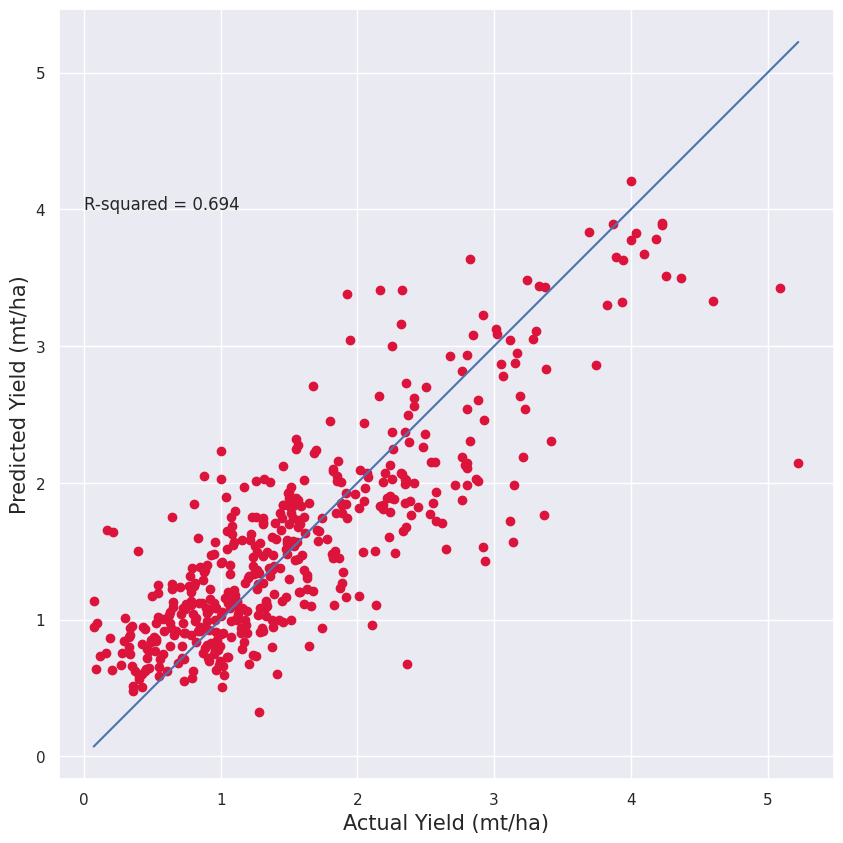

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(new_data['JoinedYld'], new_data['prediction2'], c='crimson')
# plt.yscale('log')
# plt.xscale('log')
y_test = new_data['JoinedYld']
y_predicted = new_data['prediction2']
p1 = max(max(new_data['prediction2']), max(new_data['JoinedYld']))
p2 = min(min(new_data['prediction2']), min(new_data['JoinedYld']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Yield (mt/ha)', fontsize=15)
plt.ylabel('Predicted Yield (mt/ha)', fontsize=15)
plt.axis('equal')
plt.annotate("R-squared = {:.3f}".format(r2_score(y_test, y_predicted)), (0, 4))
plt.show()

# Testing 2021 PULA dataaset

In [ ]:
from IPython.utils import frame
from pandas.core.indexes.base import PrettyDict
#Predict on 2021 data
# 1. Get Image
# 2. Predict using classifier
# 3. Extract the values of Image on PULA data add to the pula data frame
# 4. Validate the 2 values

In [ ]:
# //Define Year of Study
start = ee.Date("2022-04-01")
end = ee.Date("2022-09-15")
scale = 10000;
# prod2021 = ee.FeatureCollection("users/Prod/maize_2021")
prod2021 = ee.FeatureCollection("users/Prod/tn_maize_2022")
AOI = prod2021.geometry()
# L8 Image Collection of Interest
imgcol = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")


In [ ]:
# Setup
Map = geemap.Map()
Map.centerObject(AOI, 12)
Map.addLayer(AOI,{},'AOI')
Map

In [ ]:

## Load the L8 Collection and Processs & Get Indices
from prepareimg import l8prep,addIndices
l8 = l8prep(start,end,imgcol,AOI)
test_VIS = addIndices(l8,AOI)

In [ ]:
test_VIS.getInfo()

In [ ]:
# SELECT Indices
test_img = test_VIS.select('evi', 'gci', 'gli', 'gndvi', 'msavi', 'ndmi', 'ndvi', 'nsi','savi', 'sipi')


In [ ]:
# Classify the Test Image
classified = test_img.classify(ee_classifier)


In [ ]:
# Reduce Regions to The test Areas
test_reg = classified.reduceRegions(**{
    'collection':prod2021,
    'reducer': ee.Reducer.mean(),
    'scale': 30

})

In [ ]:
# Map.addLayer(classified,{'palette':['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
#   '74A901', '66A000', '529400', '3E8601', '207401', '056201',
#   '004C00', '023B01', '012E01', '011D01', '011301'],'min':0.07356099784374237,'max':4.364237308502197},'CLASIFIED')

In [ ]:
Map.addLayer(test_reg)

In [ ]:
# geemap.ee_export_vector(test_reg, 'test21.csv')


In [ ]:
# geemap.ee_export_image(test_img,'test_img.tif')


In [ ]:
Map

In [ ]:
test21 = pd.read_csv('/content/test21.csv')
test21

In [ ]:
#  Calculate the absolute errors
errors = abs(test21['mean'] - test21['Yield(Mt/h'])
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

In [ ]:
#view RMSE
print('RMSE:', round(sqrt(mean(absolute(scores))), 2))

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test21['Yield(Mt/h'])
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print('MAPE:', round(np.mean(mape), 2), '%.')


In [ ]:
test21[test21.isna().any(axis=1)]

In [ ]:
test21 = test21[test21['mean'].notna()]

In [ ]:
y_test = test21['Yield(Mt/h']
y_predicted = test21['mean']
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_predicted, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(y_predicted), max(y_test))
p2 = min(min(y_predicted), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Yield (mt/ha)', fontsize=15)
plt.ylabel('Predicted Yield (mt/ha)', fontsize=15)
plt.axis('equal')
plt.annotate("R-squared = {:.3f}".format(r2_score(y_test, y_predicted)), (0, 9))
plt.show()

In [ ]:
test21=test21[test21['mean'] > 0]

y_true = test21['Yield(Mt/h']
y_pred = test21['mean']
mape = mean_absolute_percentage_error(y_true, y_pred)
mse =  mean_squared_error(y_true, y_pred)
rmse =  mean_squared_error(y_true, y_pred,squared=False)
r2 =  r2_score(y_true, y_pred)
test_dict = {'index':[0],'MAPE': mape,'MSE':mse,'RMSE':rmse,'r2':r2}
test_metrics = pd.DataFrame(data=test_dict)
test_metrics

**TESTING WITH 2018 DATA**

# TESTING WITH 2021 and 2022 DATA

In [ ]:
# classified.getInfo()

In [ ]:
# Reduce Regions to The test Areas
test_reg = classified.reduceRegions(**{
    'collection':aoi.geometry(),
    'reducer': ee.Reducer.mean(),
    'scale': scale
})


In [ ]:
# test_reg.getInfo()

In [ ]:
Map.addLayer(test_reg,{'palette':['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
  '74A901', '66A000', '529400', '3E8601', '207401', '056201',
  '004C00', '023B01', '012E01', '011D01', '011301'],'min':0.07356099784374237,'max':4.364237308502197},'2018 CLASIFIED')

In [ ]:
Map

In [ ]:
task = ee.batch.Export.image.toAsset(image=classified,
                                         description='description',
                                         assetId='users/Prod/2018classified',
                                         scale=30,
                                         maxPixels=1e13,
                                         region=AOI,
                                         )
# task.start()

In [ ]:
task.status()

In [ ]:
vectors = classified.toInt().reduceToVectors(**{
  'geometry':AOI,
  'scale':30,
  'geometryType': 'Polygon',
  # 'labelProperty': 'label',
  'reducer': ee.Reducer.countEvery(),
  'tileScale':4
})


In [ ]:
Map.addLayer(vectors,{},'VECTORS')

In [ ]:
task_config = {
        'region': AOI,
        'crs': 'EPSG:3301',
        'fileFormat': 'GeoTIFF',
        'fileNamePrefix': 'Day',
        'folder':'low',
        'image': day_comp,
        'description': str(hwp_18[i])
    }
task=ee.batch.Export.image.toDrive(**task_config)
task.start()

In [ ]:
task = ee.batch.Export.vector.toAsset(image=classified,
                                         description='description',
                                         assetId='users/Prod/2018classified',
                                         scale=30,
                                         maxPixels=1e13,
                                         region=AOI,
                                         )
task.start()

In [ ]:
geemap.ee_export_vector(test_reg, 'test_2018_d.csv')


In [ ]:
# geemap.ee_export_vector_to_drive(test_reg, description="2018 TEST", folder="Validation", file_format='csv', selectors=None)


In [ ]:
# test_reg.getInfo()

In [ ]:
test18 = pd.read_csv('/content/test_2018_d.csv')
test18

In [ ]:
#  Calculate the absolute errors
errors = abs(test18['mean'] - test18['mt_ha'])
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# mae = metrics.mean_absolute_error(test18['mt_ha'], test18['mean'])
# print("MAE: ", mae)
# mse = metrics.mean_squared_error(test18['mt_ha'], test18['mean'])
# print("MSE: ", mse)

# rmse = np.sqrt(metrics.mean_squared_error(test18['mt_ha'], test18['mean']))
# print("RMSE: ", rmse)

# r2 = metrics.r2_score(test18['mt_ha'], test18['mean'])
# print("r2: ", r2)

#view RMSE
print('RMSE:', round(sqrt(mean(absolute(scores))), 2))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test18['mt_ha'])
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print('MAPE:', round(np.mean(mape), 2), '%.')

# Variance Map

In [ ]:
variance = predicted_2010.reduce(ee.Reducer.variance())

In [ ]:
Map.addLayer(variance,{},'Variance')

In [ ]:
Map

# Z-Score Maps

In [ ]:
# # Define a function to calculate the variance between images
# def variance_func(img_col):
#     first = ee.Image(img_col.first()).select("NDVI")
#     mean = img_col.mean().select("NDVI")
#     diff = img_col.map(lambda img: img.select("NDVI").subtract(mean))
#     squared_diff = diff.map(lambda img: img.pow(2))
#     return squared_diff.sum().divide(img_col.count()).sqrt()

# # Apply the function to the Image Collection
# var = variance_func(img_col)

# # Print the result
# print(var.getInfo())


In [ ]:
# #Variance
# img_mean = ee.ImageCollection([img1, img2, img3, img4, img5, img6, img7, img8, img9]).mean()

# # Calculate variance between images
# var_img = ee.ImageCollection([img1, img2, img3, img4, img5, img6, img7, img8, img9]).map(lambda img: img.subtract(img_mean).pow(2)).mean()

In [ ]:
def reduce_img_region(image):
  reduced = image.reduceRegions(**{
    'collection':aoi,
    'reducer': ee.Reducer.sum(),
    'scale': 30

})

In [ ]:
Map

In [ ]:
mergedCol_bands = mergedCollection.toBands()

In [ ]:
predicted_2010 = mergedCol_bands.classify(ee_classifier)

In [ ]:
predicted_2010.reduce(ee.Reducer.variance())

In [ ]:
predicted_2010

In [ ]:
# Map.addLayer(predicted_2010)

In [ ]:
# # # Calculate mean prediction
pred_mean = ee.ImageCollection([predicted_2010]).mean()

# # Calculate Z-score for each prediction
red_zscore = ee.ImageCollection([predicted_2010]).map(lambda img_pred: (img_pred.subtract(pred_mean)).divide(img_pred.reduceRegion(ee.Reducer.stdDev()).get('prediction')))

In [ ]:
print(red_zscore.first())

# Correlation

## **Correlation Predictor Variables vs Yield**

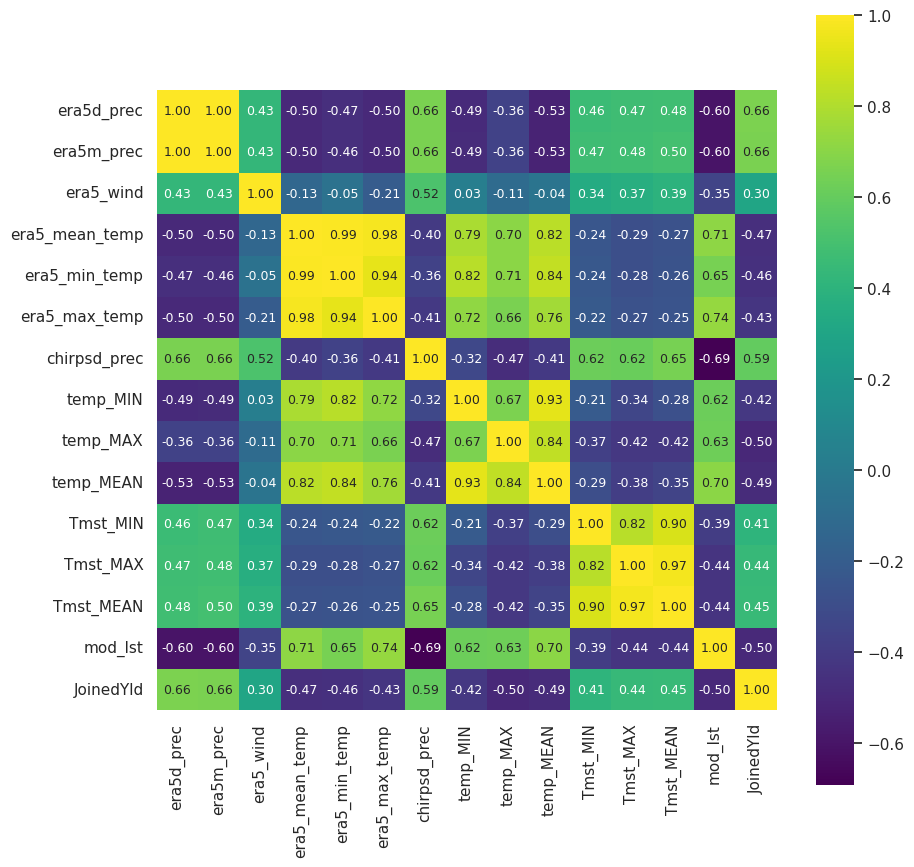

In [ ]:
# clim_var = [ 'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec',
#        'era5_mean_temp', 'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp',
#        'era5m_min_temp', 'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec',
#        'temp_MIN', 'temp_MAX', 'temp_MEAN', 'temp_STD', 'temp_SUM', 'Tmst_MIN',
#        'Tmst_MAX', 'Tmst_MEAN', 'Tmst_STD', 'Tmst_SUM','mod_lst', 'ggcp10','JoinedYld', 'Yield','Yield2','final_Yld']
clim_var = [ 'era5d_prec','era5m_prec', 'era5_wind','era5_mean_temp', 'era5_min_temp', 'era5_max_temp','chirpsd_prec',
            'temp_MIN', 'temp_MAX', 'temp_MEAN',  'Tmst_MIN','Tmst_MAX', 'Tmst_MEAN','mod_lst',
             'JoinedYld']

clim = pd.DataFrame(data, columns=clim_var)
fig = plt.figure(figsize=(10,10))

dataplot = sns.heatmap(clim.corr(),cmap="viridis", annot=True,fmt='.2f', annot_kws = {'size':9},
                       cbar_kws = dict(use_gridspec=False,location="right"),square=True)
# sns.set(font_scale=0.8)

order = feature_importance.groupby('Features').mean().sort_values('Importance',ascending=False).index
# barplot = sns.barplot(feature_importance['Importance'],feature_importance['Features'],order=order,orient = 'h',palette=("Blues_r"),ax =ax2)
# ax2.barh()
# plt.xlabel("RF Importance")
plt.show()

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


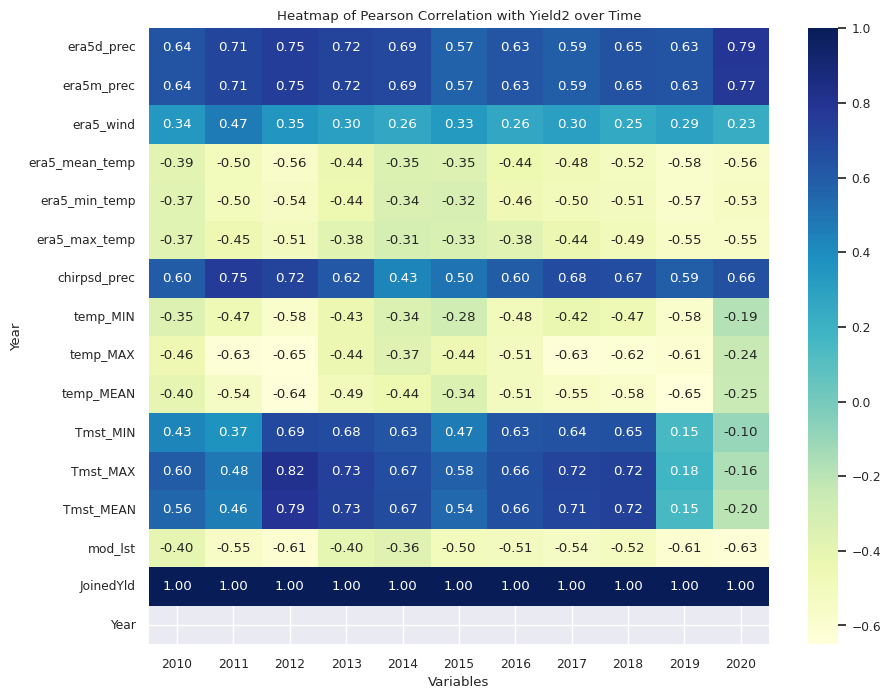

In [ ]:
# Group data by year
clim_vars =  [ 'era5d_prec','era5m_prec', 'era5_wind','era5_mean_temp', 'era5_min_temp', 'era5_max_temp','chirpsd_prec',
            'temp_MIN', 'temp_MAX', 'temp_MEAN',  'Tmst_MIN','Tmst_MAX', 'Tmst_MEAN','mod_lst','JoinedYld','Year']
climy = pd.DataFrame(data, columns=clim_vars)
grouped = climy.groupby('Year')

# Create an empty dictionary to store correlation values
correlation_data = {}

# Iterate through each year's data
for year, group_data in grouped:
    # Calculate the Pearson correlation with 'Yield2' for each column
    correlations = group_data.corrwith(group_data['JoinedYld'])

    # Store correlations for the current year
    correlation_data[year] = correlations

# Create a DataFrame from the correlation data
heatmap_data = pd.DataFrame(correlation_data)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.xlabel("Variables")
plt.ylabel("Year")
plt.title("Heatmap of Pearson Correlation with Yield2 over Time")
plt.show()

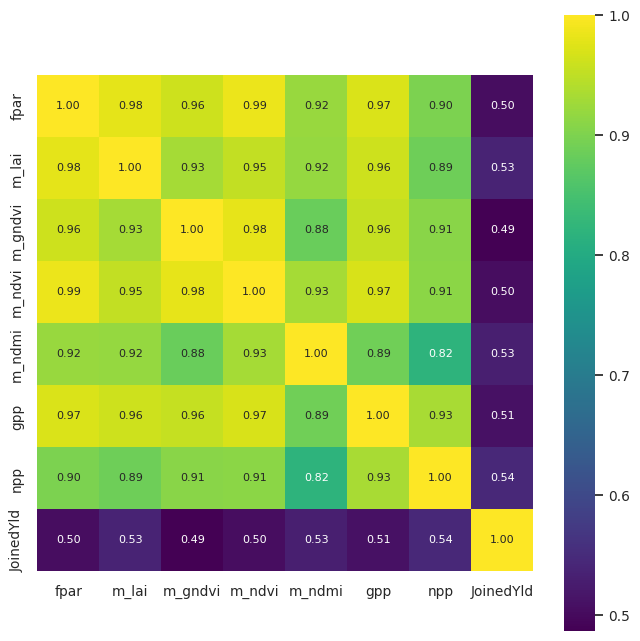

In [ ]:
mod_var = ['fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp', 'npp','JoinedYld']
mod = pd.DataFrame(data, columns=mod_var)
fig = plt.figure(figsize=(8,8))

dataplot = sns.heatmap(mod.corr(),cmap="viridis", annot=True,fmt='.2f', annot_kws = {'size':8},
                       cbar_kws = dict(use_gridspec=False,location="right"),square=True)
# sns.set(font_scale=0.8)

# order = feature_importance.groupby('Features').mean().sort_values('Importance',ascending=False).index
# barplot = sns.barplot(feature_importance['Importance'],feature_importance['Features'],order=order,orient = 'h',palette=("Blues_r"),ax =ax2)
# ax2.barh()
# plt.xlabel("RF Importance")
plt.show()

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


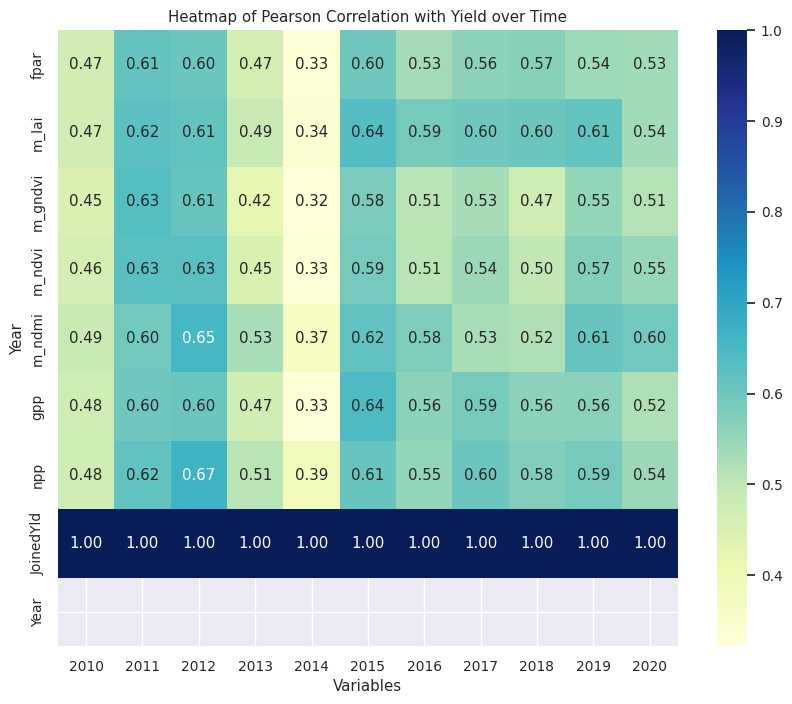

In [ ]:
# Group data by year
mod_var_y = ['fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp','npp', 'JoinedYld','Year']
mod_y = pd.DataFrame(data, columns=mod_var_y)
grouped = mod_y.groupby('Year')

# Create an empty dictionary to store correlation values
correlation_data = {}

# Iterate through each year's data
for year, group_data in grouped:
    # Calculate the Pearson correlation with 'Yield2' for each column
    correlations = group_data.corrwith(group_data['JoinedYld'])

    # Store correlations for the current year
    correlation_data[year] = correlations

# Create a DataFrame from the correlation data
heatmap_data = pd.DataFrame(correlation_data)
sns.set(font_scale=0.9)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.xlabel("Variables")
plt.ylabel("Year")
plt.title("Heatmap of Pearson Correlation with Yield over Time")
plt.show()

In [ ]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# y = mod['Yield2']
# X = mod.drop(['Yield2','Yield'], axis =1)
# # calculate VIF for each feature
# vif = pd.DataFrame([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
#                    index=X.columns, columns=['VIF'])

# if vif['VIF'].max() < 10:
#     high_vif_feature = vif['VIF'].idxmax()
#     X.drop(high_vif_feature, axis=1, inplace=True)
# vif

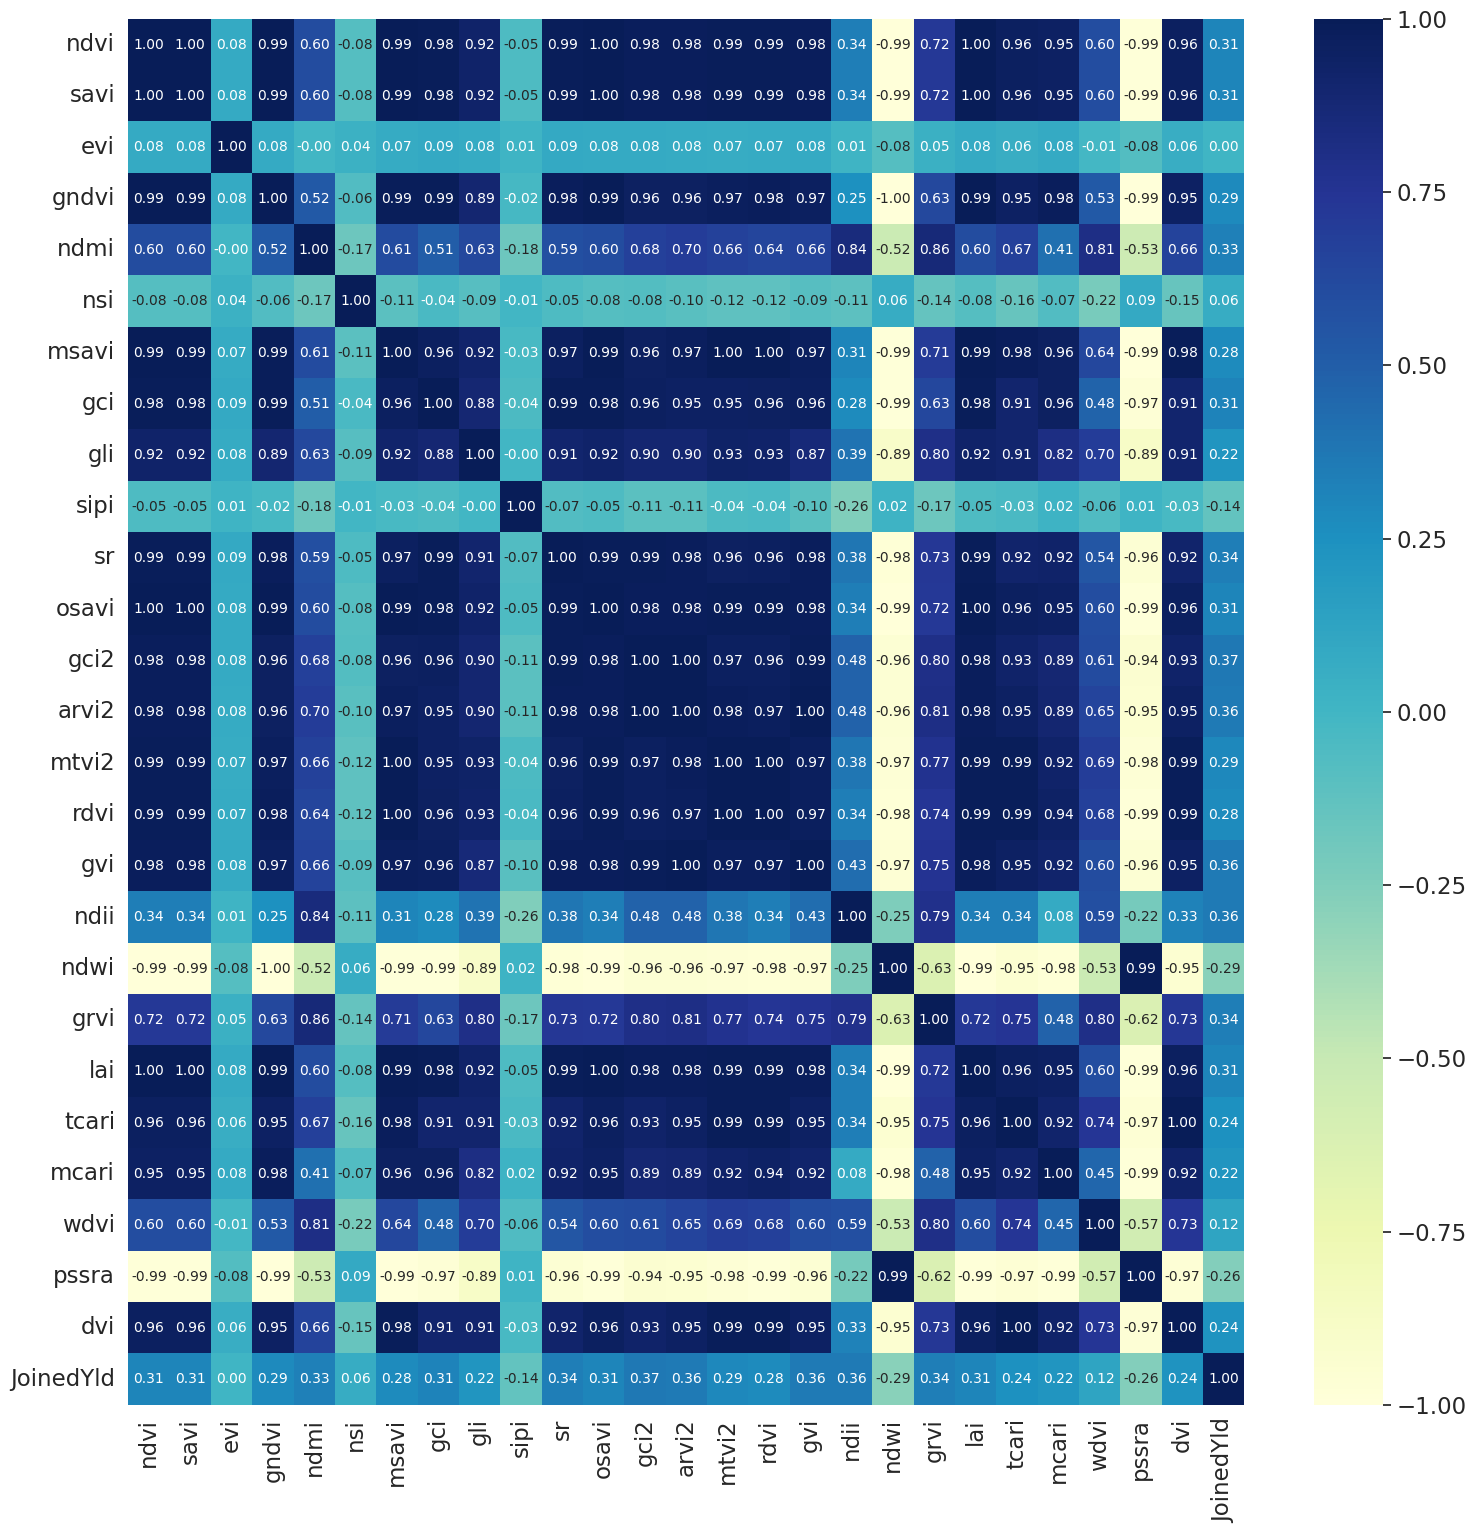

In [ ]:
indx_var = ['ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi',
       'msavi', 'gci', 'gli', 'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2',
       'rdvi', 'gvi', 'ndii', 'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi',
       'pssra', 'dvi', 'JoinedYld']
indx = pd.DataFrame(data, columns=indx_var)
fig = plt.figure(figsize=(18,18))

dataplot = sns.heatmap(indx.corr(),cmap="YlGnBu", annot=True,fmt='.2f', annot_kws = {'size':10},
                       cbar_kws = dict(use_gridspec=False,location="right"),square=False)
sns.set(font_scale=2)
dataplot.set(xlabel="", ylabel="")
# order = feature_importance.groupby('Feature').mean().sort_values('Importance',ascending=False).index
# barplot = sns.barplot(feature_importance['Importance'],feature_importance['Features'],order=order,orient = 'h',palette=("Blues_r"),ax =ax2)
# ax2.barh()
# plt.xlabel("RF Importance")
plt.show()

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


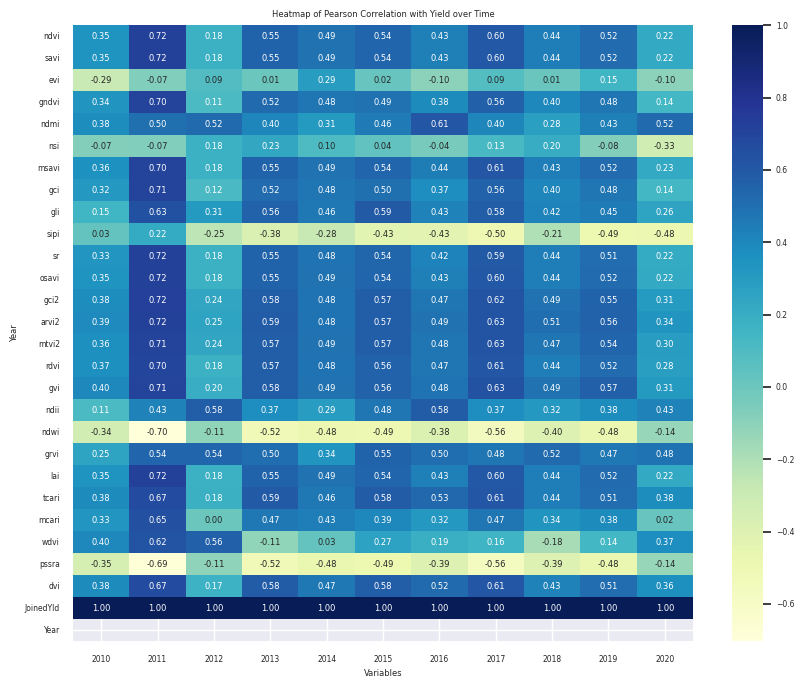

In [ ]:
indx_var_y = ['ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi',
       'msavi', 'gci', 'gli', 'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2',
       'rdvi', 'gvi', 'ndii', 'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi',
       'pssra', 'dvi', 'JoinedYld', 'Year']
indx_y = pd.DataFrame(data, columns=indx_var_y)
# Group data by year
grouped = indx_y.groupby('Year')

# Create an empty dictionary to store correlation values
correlation_data = {}

# Iterate through each year's data
for year, group_data in grouped:
    # Calculate the Pearson correlation with 'Yield2' for each column
    correlations = group_data.corrwith(group_data['JoinedYld'])

    # Store correlations for the current year
    correlation_data[year] = correlations

# Create a DataFrame from the correlation data
heatmap_data = pd.DataFrame(correlation_data)
sns.set(font_scale=0.5)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.xlabel("Variables")
plt.ylabel("Year")
plt.title("Heatmap of Pearson Correlation with Yield over Time")
plt.show()